<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, flat_field step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and flat_field validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS), [IFU test](#IFU) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
import os
from astropy.io import fits

from jwst.flatfield.flat_field_step import FlatFieldStep

# This installs the latest version of PTT
import subprocess
subprocess.run(['pip', 'install', 'git+https://github.com/spacetelescope/nirspec_pipe_testing_tool@1.0.2'])
import nirspec_pipe_testing_tool as nptt


In [2]:
# Make sure that the version used is the right one

# to get the latest version from master run:
#import subprocess
#subprocess.run(['pip', 'install', 'git+https://github.com/spacetelescope/nirspec_pipe_testing_tool@master'])

# latest stable version: git+https://github.com/spacetelescope/nirspec_pipe_testing_tool@1.0.2,
# this is what has to go in the requirements.txt file of this repo
latest_nptt_stable_version = '1.0.2'
nptt_version = nptt.__version__

if nptt_version != latest_nptt_stable_version:
    print("* WARNING - The code might break because the version used is not the latest stable version:")
    print("            Latest stable version is ", latest_nptt_stable_version)
    print("            Using NPTT version ", nptt_version)

Using NPTT version:  0.1.dev445+g7125751
* WARNING: The code might break because the version used is not the current NPTT working version


<a id="intro_ID"></a>
# Introduction

The test is a direct comparison of the result of our implementation of the flat field step algorithm versus the pipeline's implementation, i.e.: 
              difference =  absolute( Flat_nirspec_implementation - Flat_pipeline)

We expect the absolute difference to be of the order of 1x10^-6. We set this threshold by assuming that the difference should yield computer precision 1x10^-7 numbers. We then relaxed one order of magnitude due to interpolation differences in the algorithms.

For the test to be considered PASSED, every single slit (for FS data), slitlet (for MOS data) or slice (for IFU data) in the input file has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test for Fixed Slits (FS) can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/flattest_fs.py. For Multi Object Spectroscopy (MOS), the code is in the same repository but is named ```flattest_mos.py```, and for Integral Field Unit (IFU) data, the test is named ```flattest_ifu.py```.

The input file is defined in the variable ```input_file``` (see section [Testing Data Set and Variable Setup](#data_ID)).

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/main.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/flatfield


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+Flat+Field+Correction


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing:
- FS - FULLFRAME, G140M, OPAQUE
- FS - ALLSLITS, G235H, F170LP 
- IFU - G395H, OPAQUE  and  PRISM, CLEAR
- MOS - G140M, F100LP 

The testing data can be located at ```/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite```

In that directory you will find a subdirectory for CV3 data for FS, MOS, and IFU, as well as other campaigns. This notebook is specifically written for CV3 data.

Benchmarking PTT is out of the scope of this Notebook, but if you are interested, please go to the PTT repository at:
https://github.com/spacetelescope/nirspec_pipe_testing_tool. There, you can follow the Quick Start Guide to either run everything (from cal_detector1) or start directly from spec2 - if you want to download data, the only file you need is gain_scale_NRS1.fits, since this is the input file for the spec2 pipeline. The benchmark test data can be located at: 
```/grp/jwst/wit4/nirspec_vault/pipe_testing_tool/PTT_FS_benchmark_run```
In that directory you will find:
- NRSV84600010001P0000000002101_4_491_SE_2016-01-17T17h34m08.fits (which is what we call the raw_data_file)
- gain_scale_NRS1.fits (which is the final output of cal_detector1 and the input file for your test)
- results_491 (directory that contains results of my tests, in case you want to compare your results)
- PTT_config.cfg  (a sample of a configuration file for PTT, in case you want to compare with the one you create in the test)


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and assign_wcs validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the assign_wcs step, use the command:

$ strun jwst.assign_wcs.AssignWcsStep jwtest_rate.fits

NIRSpec TA data will be run through the cal_detector1 and the imaging2 pipelines. The imaging pipeline can be run with the following fommand:

$ strun jwst.pipeline.Image2Pipeline jwtest_rate.fits

These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
 
$\gt$ AssignWcsStep.call(jwtest_rate.fits)

For the imaging pipeline the call would be as follows:

$\gt$ from jwst.pipeline.calwebb_image2 import Image2Pipeline

$\gt$ Image2Pipeline.call(jwtest_rate.fits)

PTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use PTT to run the pipeline and the validation tests.

To run PTT you first need to create and edit the file that controls the tool. This configuration file tells PTT which data to test, the mode, and where to put results and plots, among other variables that can be modified from the default values (e.g. paths for the flat field reference files, acceptance threshold values for differences between pipeline product and benchmark files, modify a benchmark file, etc).

[Top of Page](#title_ID)

-> For each mode, the following variables will need to be set:
- output_directory = string, path where you want intermediary files and plots to be saved in, if writefile=True
- input_file = string or object, this is the output file from the previous step, e.g. jwtest1_NRS1_extract2d.fits
- dflat_path = string, path of where the D-flat reference fits files
- sflat_path = string, path of where the S-flat reference fits files
- fflat_path = string, path of where the F-flat reference fits files
- writefile = boolean, if True writes the fits files of the calculated flat, and the difference jpeg images
- save_figs = boolean, whether to save plots or not
- show_figs = boolean, whether to show plots or not 
- threshold_diff = float, threshold difference between pipeline output and ESA file


<a id="FULLFRAME"></a>
# FS FULL-FRAME test

In [18]:
## Set the variables for Fixed Slit (FS) data
output_directory = '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G140M_opaque/'
input_file = 'gain_scale_NRS1_extract_2d.fits'
input_file = os.path.join(output_directory, input_file)
dflat_path = '/grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.2_D_Flat/nirspec_dflat'
sflat_path = '/grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.3_S_Flat/FS/nirspec_FS_sflat'
fflat_path = '/grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.1_F_Flat/FS/nirspec_FS_fflat'
writefile = False
save_figs = False
show_figs = True
threshold_diff = 9.999e-5

In [28]:
# Run the pipeline step
pipe_result = input_file.replace("extract_2d.fits", "flat_field.fits")
FlatFieldStep.call(input_file, output_file=pipe_result, save_interpolated_flat=True)

# Move the output files to the output directory
subprocess.run(['mv', os.path.basename(input_file).replace('extract_2d.fits', 'flatfieldstep.fits'), pipe_result])
interpolated_flat = input_file.replace("extract_2d.fits", "interpolatedflat.fits")
subprocess.run(['mv', os.path.basename(input_file).replace('extract_2d.fits', 'interpolatedflat.fits'), interpolated_flat])


CompletedProcess(args=['mv', 'gain_scale_NRS1_interpolatedflat.fits', '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G140M_opaque/gain_scale_NRS1_interpolatedflat.fits'], returncode=0)

step_input_filename=/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G140M_opaque/gain_scale_NRS1_flat_field.fits
filename: gain_scale_NRS1_extract_2d.fits
date: 2020-04-14T12:03:30.951
model_type: MultiSlitModel
----------------------------------------------------------------------
attribute                               size                type
----------------------------------------------------------------------
slits[0].data                           (1382,48)           float32
slits[0].dq                             (1382,48)           uint32
slits[0].err                            (1382,48)           float32
slits[0].var_poisson                    (1382,48)           float32
slits[0].var_rnoise                     (1382,48)           float32
slits[0].wavelength                     (1382,48)           float32
slits[1].data                           (1466,50)           float32
slits[1].dq                             (1466,50)           uint32
slits

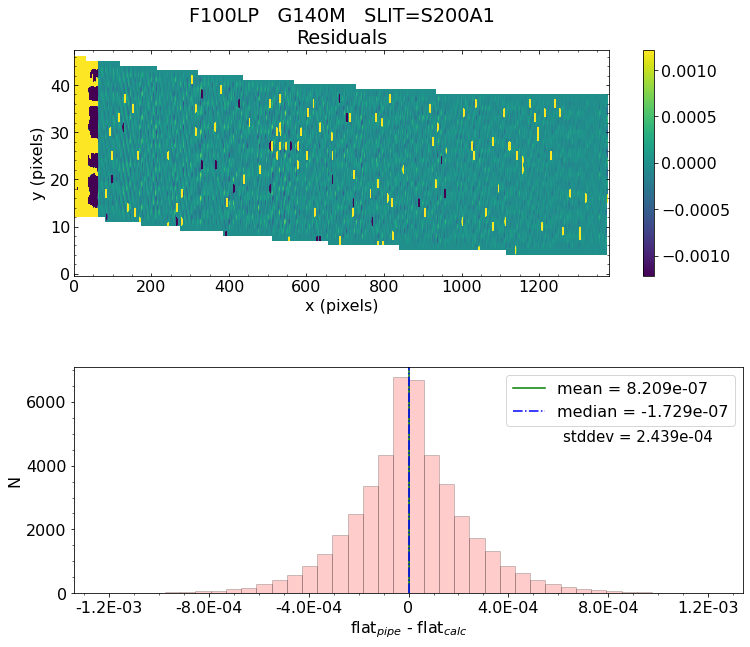


Working with slit: S200A2
 Subwindow origin:   px0=476   py0=1017
 Looping through the wavelengths... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = -4.507e-07    median = -3.178e-07    stdev = 2.348e-04
    Maximum   AbsoluteFlat Difference = 1.332e-03
    Minimum   AbsoluteFlat Difference = -1.375e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 57%
                            ->  3xtheshold = 17%
                            ->  5xtheshold = 5%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 *** Result of the test: PASSED



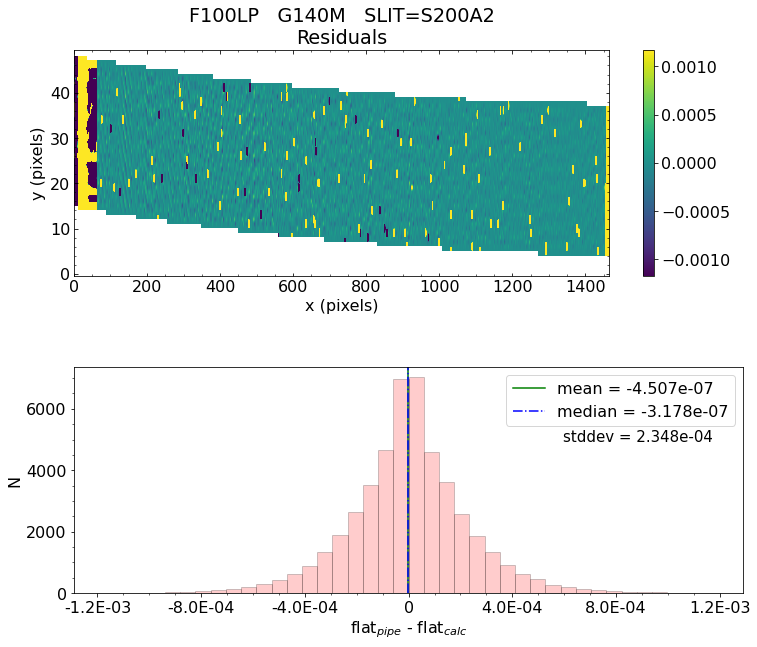


Working with slit: S400A1
 Subwindow origin:   px0=597   py0=977
 Looping through the wavelengths... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = 9.321e-08    median = 1.029e-07    stdev = 4.742e-04
    Maximum   AbsoluteFlat Difference = 3.056e-03
    Minimum   AbsoluteFlat Difference = -3.267e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 74%
                            ->  3xtheshold = 43%
                            ->  5xtheshold = 23%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 *** Result of the test: PASSED



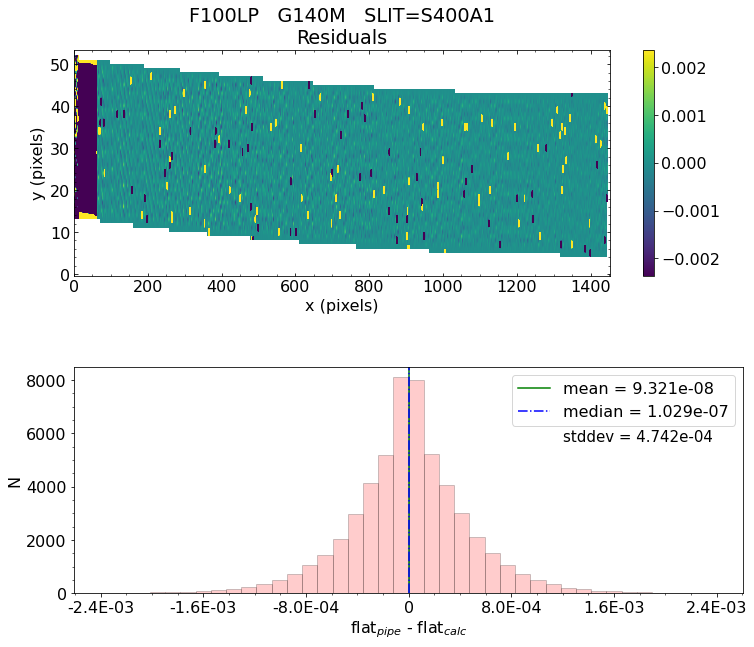


Working with slit: S1600A1
 Subwindow origin:   px0=621   py0=957
 Looping through the wavelengths... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = 7.008e-05    median = 2.708e-05    stdev = 3.469e-03
    Maximum   AbsoluteFlat Difference = 3.943e-02
    Minimum   AbsoluteFlat Difference = -3.921e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 96%
                            ->  3xtheshold = 88%
                            ->  5xtheshold = 80%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 *** Result of the test: PASSED



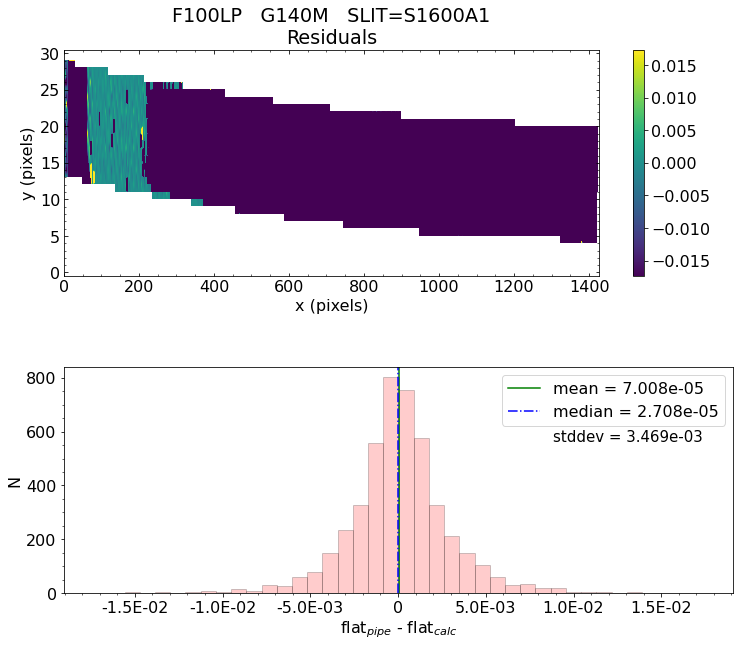


 *** Final result for flat_field test will be reported as PASSED *** 

('* Script flattest_fs.py took ', '3.8909423470497133 minutes to finish.')


In [31]:
# Run the validation test
%matplotlib inline
result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.flattest_fs.flattest(pipe_result,
                                                                                                   dflat_path=dflat_path,
                                                                                                   sflat_path=sflat_path, 
                                                                                                   fflat_path=fflat_path,
                                                                                                   writefile=writefile,
                                                                                                   show_figs=show_figs, 
                                                                                                   save_figs=save_figs,
                                                                                                   plot_name=None,
                                                                                                   threshold_diff=threshold_diff,
                                                                                                   output_directory=output_directory, 
                                                                                                   debug=False)


In [52]:
# Quickly see if the test passed 
   
print("Did flat_field validation for FS FULL-FRAME test passed? ", result_msg)


Did flat_field validation for FS FULL-FRAME test passed?  Wrong path in for mode S-flat. Test skiped because mode is not FS.


<a id="ALLSLITS"></a>
# FS ALLSLITS test

In [38]:
# Set the variables 
output_directory = '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_ALLSLITS/G235M_F170LP'
input_file = 'final_output_caldet1_NRS1_extract_2d.fits'
input_file = os.path.join(output_directory, input_file)
dflat_path = '/grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.2_D_Flat/nirspec_dflat'
sflat_path = '/grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.3_S_Flat/FS/nirspec_FS_sflat'
fflat_path = '/grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.1_F_Flat/FS/nirspec_FS_fflat'
writefile = False
save_figs = False
show_figs = True
threshold_diff = 9.999e-5

In [39]:
# Run the pipeline step
pipe_result = input_file.replace("extract_2d.fits", "flat_field.fits")
FlatFieldStep.call(input_file, output_file=pipe_result, save_interpolated_flat=True)

# Move the output files to the output directory
subprocess.run(['mv', os.path.basename(input_file).replace('extract_2d.fits', 'flatfieldstep.fits'), pipe_result])
interpolated_flat = input_file.replace("extract_2d.fits", "interpolatedflat.fits")
subprocess.run(['mv', os.path.basename(input_file).replace('extract_2d.fits', 'interpolatedflat.fits'), interpolated_flat])


2020-05-06 13:25:57,281 - CRDS - ERROR -  Error determining best reference for 'pars-flatfieldstep'  =   Unknown reference type 'pars-flatfieldstep'
2020-05-06 13:25:57,283 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2020-05-06 13:25:57,401 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args ('/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_ALLSLITS/G235M_F170LP/final_output_caldet1_NRS1_extract_2d.fits',).
2020-05-06 13:25:57,403 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_ALLSLITS/G235M_F170LP/final_output_caldet1_NRS1_flat_field.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': True}
2020-05-06 13:26:04,11

CompletedProcess(args=['mv', 'final_output_caldet1_NRS1_interpolatedflat.fits', '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_ALLSLITS/G235M_F170LP/final_output_caldet1_NRS1_interpolatedflat.fits'], returncode=0)

step_input_filename=/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_ALLSLITS/G235M_F170LP/final_output_caldet1_NRS1_flat_field.fits
filename: final_output_caldet1_NRS1_extract_2d.fits
date: 2019-10-29T12:31:25.166
model_type: MultiSlitModel
----------------------------------------------------------------------
attribute                               size                type
----------------------------------------------------------------------
slits[0].data                           (1337,47)           float32
slits[0].dq                             (1337,47)           uint32
slits[0].err                            (1337,47)           float32
slits[0].var_poisson                    (1337,47)           float32
slits[0].var_rnoise                     (1337,47)           float32
slits[0].wavelength                     (1337,47)           float32
slits[1].data                           (1435,49)           float32
slits[1].dq                             (1435,49)     

2020-05-06 13:29:54,030 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/flattest_fs.py:566: RuntimeWarning: invalid value encountered in less
  difference_img = (pipeflat - flatcor)  # /flatcor

2020-05-06 13:29:54,031 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/flattest_fs.py:567: RuntimeWarning: invalid value encountered in greater
  in_slit = np.logical_and(difference_img < 900.0,



Calculating statistics... 
 * Unable to calculate statistics because difference array has all outlier values. Test will be set to FAILED.
 *** Result of the test: FAILED



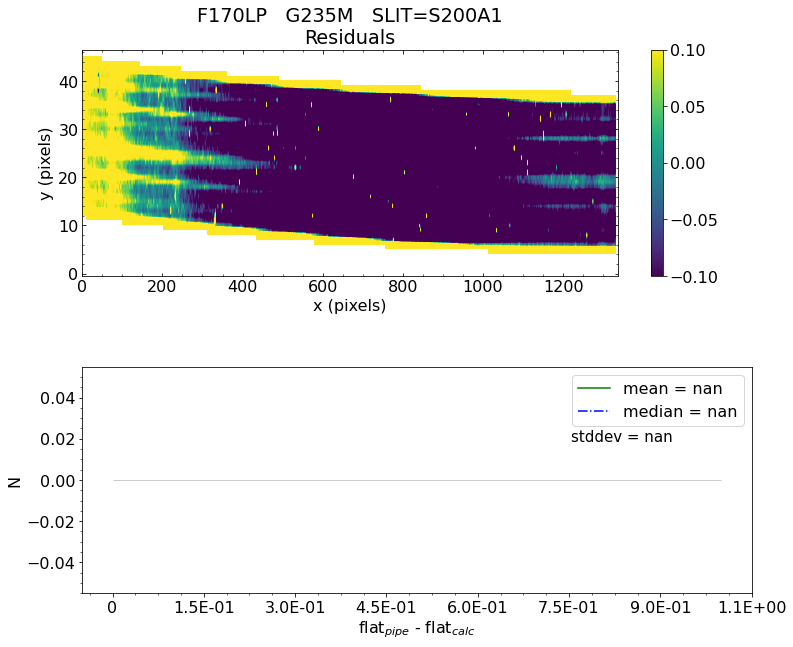


Working with slit: S200A2
 Subwindow origin:   px0=521   py0=1018
 Looping through the wavelengths... 
Calculating statistics... 
 * Unable to calculate statistics because difference array has all outlier values. Test will be set to FAILED.
 *** Result of the test: FAILED



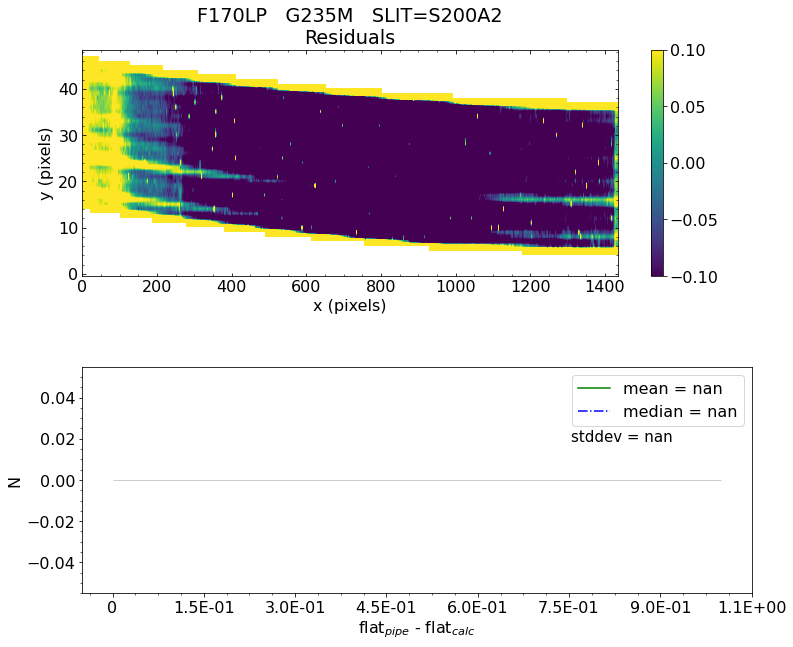


Working with slit: S400A1
 Subwindow origin:   px0=642   py0=978
 Looping through the wavelengths... 
Calculating statistics... 
 * Unable to calculate statistics because difference array has all outlier values. Test will be set to FAILED.
 *** Result of the test: FAILED



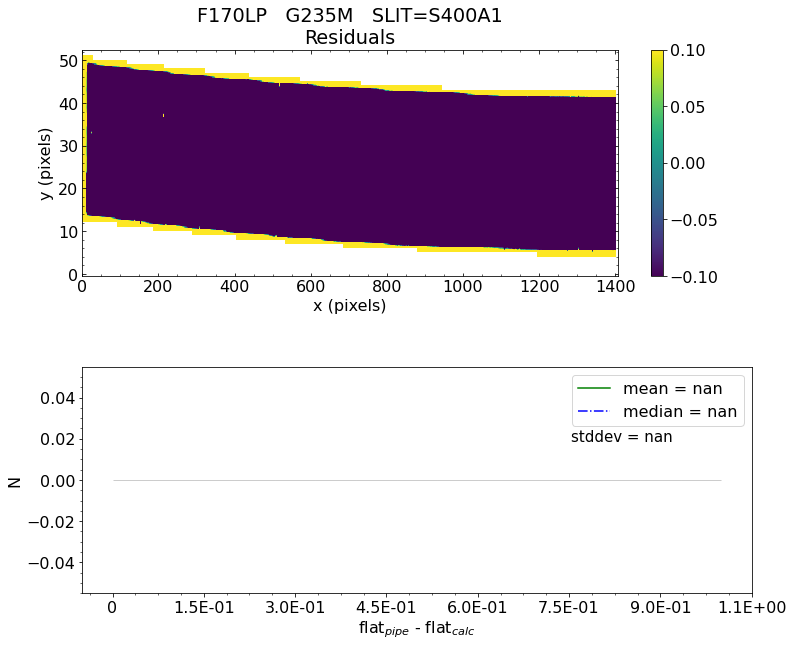


Working with slit: S1600A1
 Subwindow origin:   px0=666   py0=958
 Looping through the wavelengths... 
Calculating statistics... 
 * Unable to calculate statistics because difference array has all outlier values. Test will be set to FAILED.
 *** Result of the test: FAILED



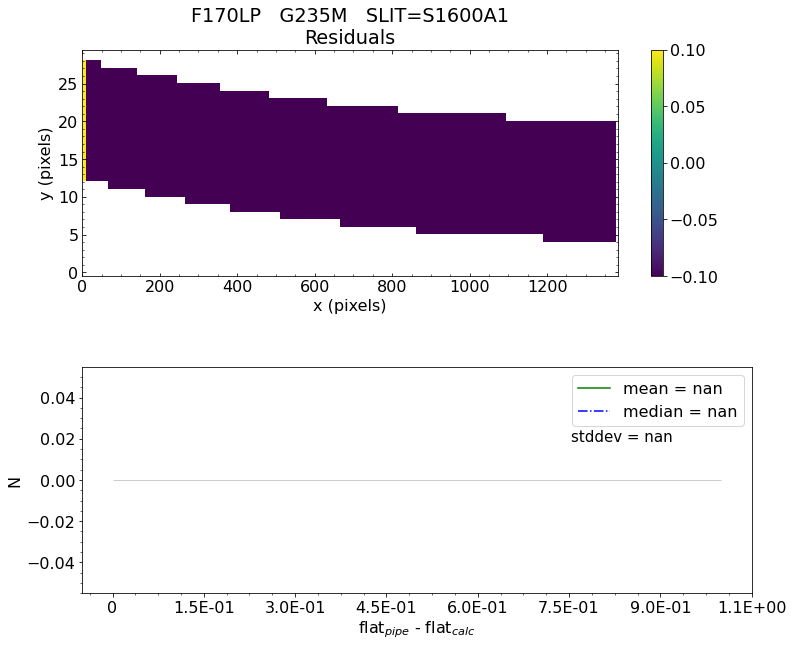


 *** Final result for flat_field test will be reported as FAILED *** 

('* Script flattest_fs.py took ', '5.033118685086568 minutes to finish.')


In [40]:
# Run the validation test
%matplotlib inline
result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.flattest_fs.flattest(pipe_result,
                                                                                              dflat_path=dflat_path,
                                                                                              sflat_path=sflat_path, 
                                                                                              fflat_path=fflat_path,
                                                                                              writefile=writefile,
                                                                                              show_figs=show_figs, 
                                                                                              save_figs=save_figs,
                                                                                              plot_name=None,
                                                                                              threshold_diff=threshold_diff,
                                                                                              output_directory=output_directory, 
                                                                                              debug=False)

In [41]:
# Quickly see if the test passed 
   
print("Did flat_field validation test for FS ALLSLITS passed? ", result_msg)


Did flat_field validation test for FS ALLSLITS passed?  False


<a id="MOS"></a>
# MOS test

In [2]:
# Set the variables 
output_directory = '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/MOS/G140M_LINE1'
msa_shutter_conf = os.path.join(output_directory,'V8460001000101_new_msa.fits')
input_file = 'final_output_caldet1_NRS1_extract_2d.fits'
input_file = os.path.join(output_directory, input_file)
dflat_path = '/grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.2_D_Flat/nirspec_dflat'
sflat_path = '/grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.3_S_Flat/MOS/nirspec_MOS_sflat'
fflat_path = '/grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.1_F_Flat/MOS/nirspec_MOS_fflat'
writefile = False
save_figs = False
show_figs = True
threshold_diff = 9.999e-5

In [4]:
# Run the pipeline step
pipe_result = input_file.replace("extract_2d.fits", "flat_field.fits")
FlatFieldStep.call(input_file, output_file=pipe_result, save_interpolated_flat=True)

# Move the output files to the output directory
subprocess.run(['mv', os.path.basename(input_file).replace('extract_2d.fits', 'flatfieldstep.fits'), pipe_result])
interpolated_flat = input_file.replace("extract_2d.fits", "interpolatedflat.fits")
subprocess.run(['mv', os.path.basename(input_file).replace('extract_2d.fits', 'interpolatedflat.fits'), interpolated_flat])


step_input_filename=/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/MOS/G140M_LINE1/final_output_caldet1_NRS1_flat_field.fits
rate_file  -->     Grating:G140M   Filter:F100LP   Lamp:LINE1   EXP_TYPE:NRS_MSASPEC
Using D-flat: /grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.2_D_Flat/nirspec_dflat_nrs1_f_01.03.fits
Using S-flat: /grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.3_S_Flat/MOS/nirspec_MOS_sflat_G140M_OPAQUE_FLAT1_nrs1_f_01.01.fits
Using F-flat: /grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.1_F_Flat/MOS/nirspec_MOS_fflat_F100LP_01.01.fits
Filename: /Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/MOS/G140M_LINE1/final_output_caldet1_NRS1_interpolatedflat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     275   ()      
  1  SCI           1 ImageHDU        14   (506, 14)   float32   
  2  DQ            1 ImageHDU        11   (506, 14)   int32 (rescales to uint32)   
  3  WAVELENGTH    1 ImageHDU    

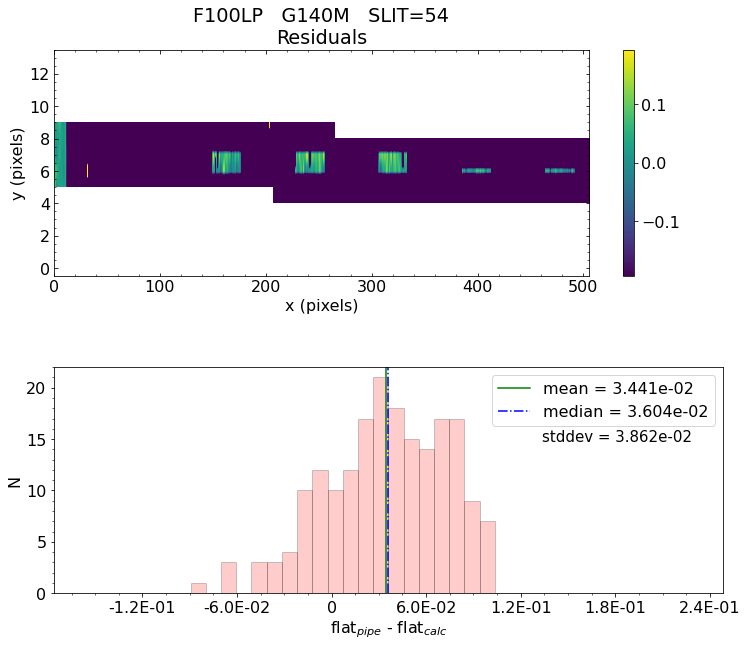

 *** Result of the test: FAILED


Working with slit: 42
 Subwindow origin:   px0=2019   py0=546
silt_id='42'   quad=2   row=138   col=56   slitlet_id='138_56'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 
 * Unable to calculate statistics because difference array has all outlier values.
   Test will be set to FAILED and NO plots will be made.
 *** Result of the test: FAILED


Working with slit: 43
 Subwindow origin:   px0=1971   py0=415
silt_id='43'   quad=2   row=155   col=82   slitlet_id='155_82'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 
 * Unable to calculate statistics because difference array has all outlier values.
   Test will be set to FAILED and NO plots will be made.
 *** Result of the test: FAILED


Working with slit: 44
 Subwindow origin:   px0=1970   py0=405
silt_id='44'   quad=2   row=155   col=84   slitlet_id='155_84'
Now looping through the pixels, this will take a while ... 
Calculati

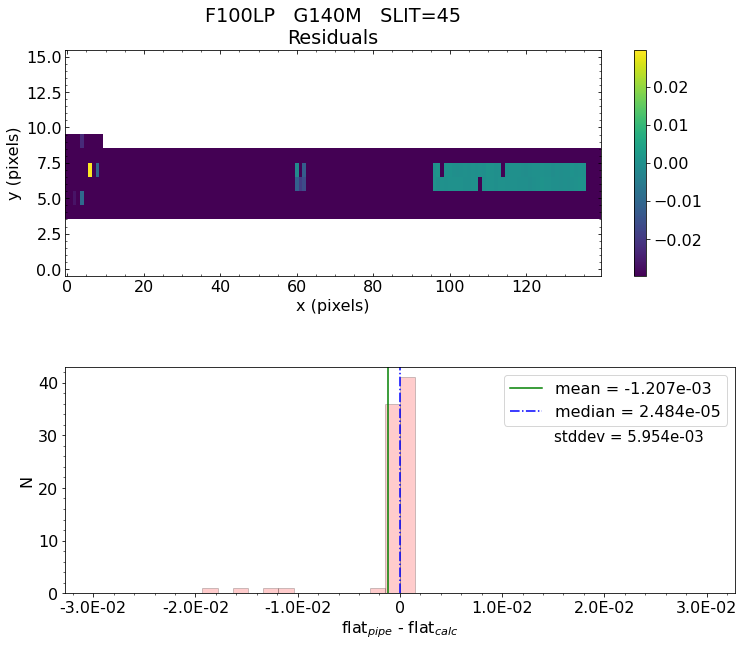

 *** Result of the test: PASSED


Working with slit: 46
 Subwindow origin:   px0=1883   py0=203
silt_id='46'   quad=2   row=186   col=124   slitlet_id='186_124'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = -2.342e-03    median = -8.872e-05    stdev = 1.116e-02
    Maximum   AbsoluteFlat Difference = 4.334e-02
    Minimum   AbsoluteFlat Difference = -3.045e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 78%
                            ->  3xtheshold = 62%
                            ->  5xtheshold = 55%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

Making histogram plot for this slitlet...


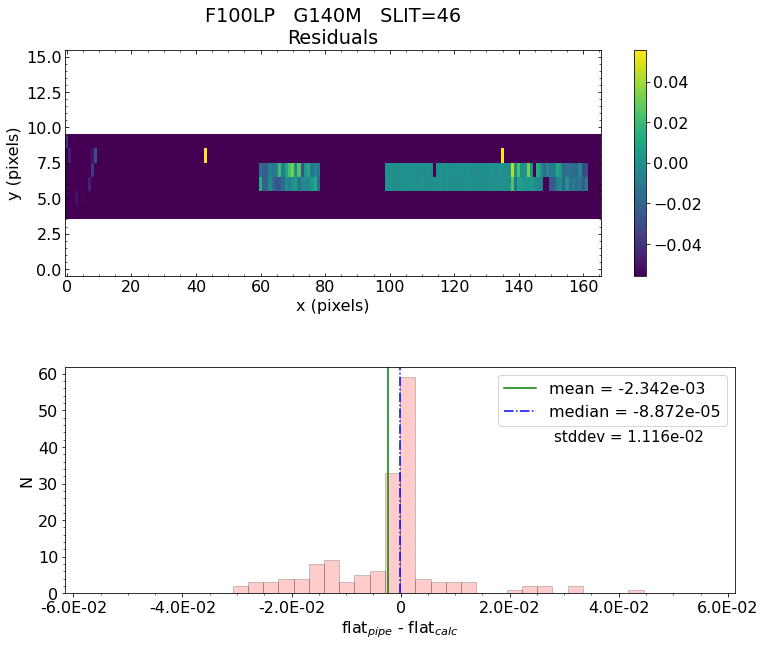

 *** Result of the test: PASSED


Working with slit: 47
 Subwindow origin:   px0=1816   py0=567
silt_id='47'   quad=2   row=216   col=52   slitlet_id='216_52'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = -3.227e-03    median = -5.326e-05    stdev = 1.107e-02
    Maximum   AbsoluteFlat Difference = 4.514e-02
    Minimum   AbsoluteFlat Difference = -8.892e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 78%
                            ->  3xtheshold = 59%
                            ->  5xtheshold = 46%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

Making histogram plot for this slitlet...


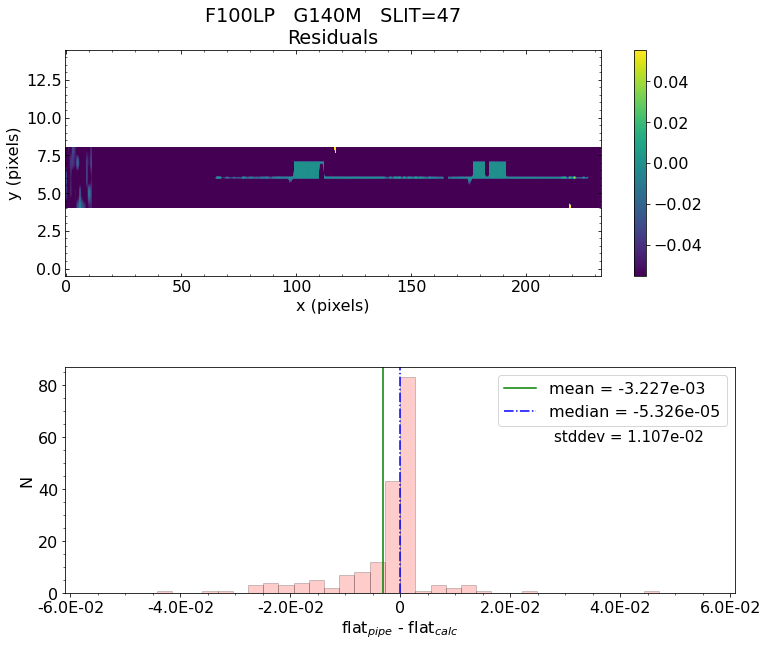

 *** Result of the test: PASSED


Working with slit: 48
 Subwindow origin:   px0=1816   py0=562
silt_id='48'   quad=2   row=216   col=53   slitlet_id='216_53'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = -1.661e-03    median = -1.291e-05    stdev = 7.838e-03
    Maximum   AbsoluteFlat Difference = 2.191e-02
    Minimum   AbsoluteFlat Difference = -4.369e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 77%
                            ->  3xtheshold = 60%
                            ->  5xtheshold = 46%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

Making histogram plot for this slitlet...


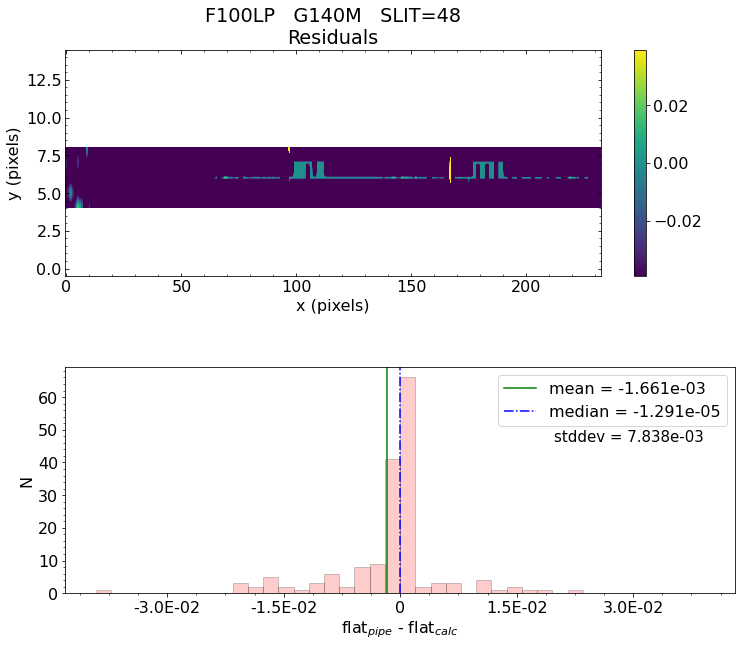

 *** Result of the test: PASSED


Working with slit: 49
 Subwindow origin:   px0=1792   py0=632
silt_id='49'   quad=2   row=226   col=39   slitlet_id='226_39'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = -3.427e-03    median = 9.938e-06    stdev = 1.575e-02
    Maximum   AbsoluteFlat Difference = 4.440e-02
    Minimum   AbsoluteFlat Difference = -9.910e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 83%
                            ->  3xtheshold = 64%
                            ->  5xtheshold = 53%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

Making histogram plot for this slitlet...


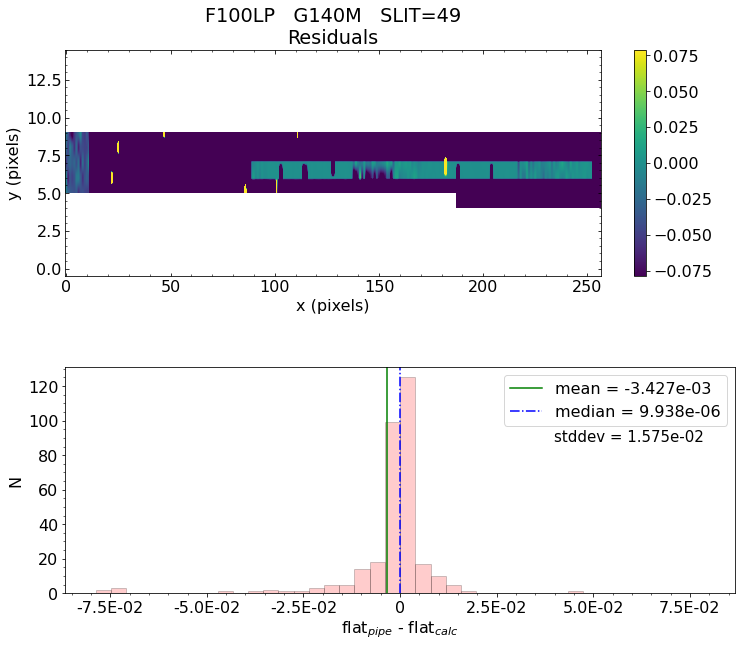

 *** Result of the test: PASSED


Working with slit: 50
 Subwindow origin:   px0=1775   py0=239
silt_id='50'   quad=2   row=228   col=117   slitlet_id='228_117'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 
 * Unable to calculate statistics because difference array has all outlier values.
   Test will be set to FAILED and NO plots will be made.
 *** Result of the test: FAILED


Working with slit: 51
 Subwindow origin:   px0=1760   py0=431
silt_id='51'   quad=2   row=236   col=79   slitlet_id='236_79'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = -6.449e-03    median = -1.749e-03    stdev = 1.003e-02
    Maximum   AbsoluteFlat Difference = 5.814e-03
    Minimum   AbsoluteFlat Difference = -3.692e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 82%
                            ->  3xthesho

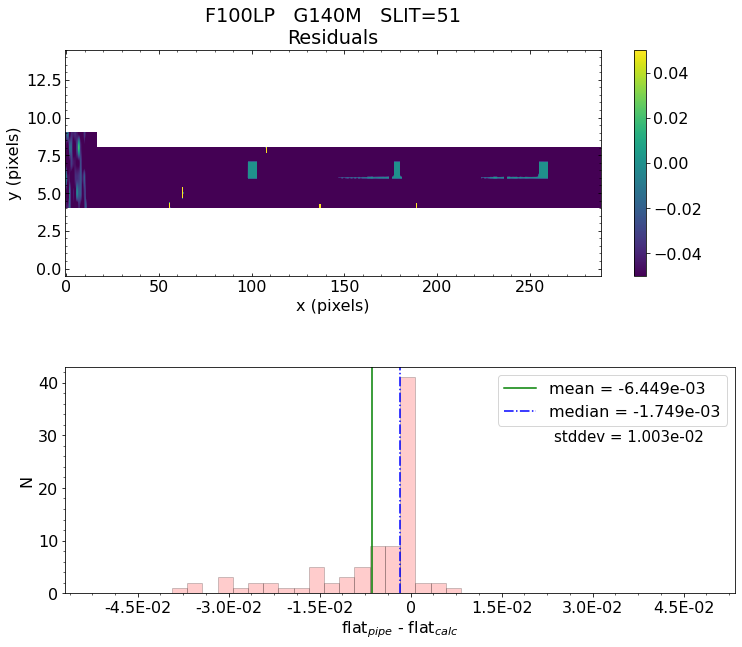

 *** Result of the test: FAILED


Working with slit: 52
 Subwindow origin:   px0=1723   py0=804
silt_id='52'   quad=2   row=255   col=5   slitlet_id='255_5'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = -8.086e-03    median = -1.382e-04    stdev = 2.005e-02
    Maximum   AbsoluteFlat Difference = 2.834e-02
    Minimum   AbsoluteFlat Difference = -9.963e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 80%
                            ->  3xtheshold = 63%
                            ->  5xtheshold = 55%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

Making histogram plot for this slitlet...


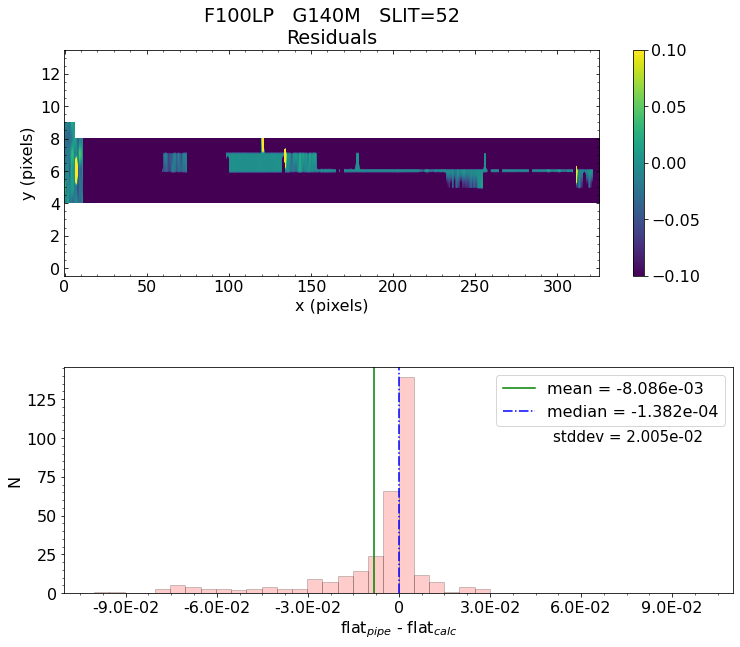

 *** Result of the test: FAILED


Working with slit: 55
 Subwindow origin:   px0=1023   py0=1416
silt_id='55'   quad=3   row=82   col=124   slitlet_id='82_124'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = 3.580e-03    median = 2.847e-05    stdev = 1.488e-02
    Maximum   AbsoluteFlat Difference = 9.858e-02
    Minimum   AbsoluteFlat Difference = -3.310e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 73%
                            ->  3xtheshold = 51%
                            ->  5xtheshold = 46%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

Making histogram plot for this slitlet...


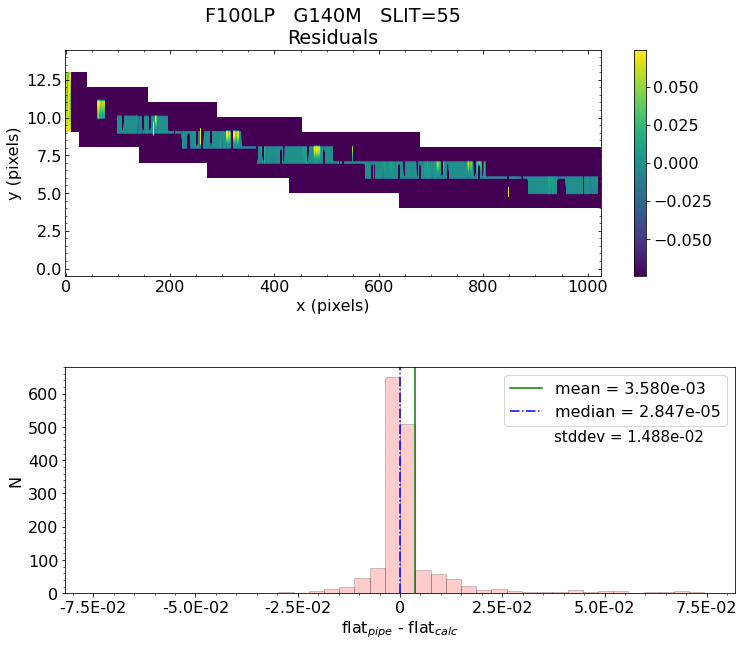

 *** Result of the test: PASSED


Working with slit: 65
 Subwindow origin:   px0=428   py0=1252
silt_id='65'   quad=3   row=310   col=156   slitlet_id='310_156'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 
 * Unable to calculate statistics because difference array has all outlier values.
   Test will be set to FAILED and NO plots will be made.
 *** Result of the test: FAILED


Working with slit: 66
 Subwindow origin:   px0=427   py0=1453
silt_id='66'   quad=3   row=314   col=116   slitlet_id='314_116'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = -1.778e-03    median = -2.148e-05    stdev = 1.967e-02
    Maximum   AbsoluteFlat Difference = 9.954e-02
    Minimum   AbsoluteFlat Difference = -9.950e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 70%
                            ->  3xthes

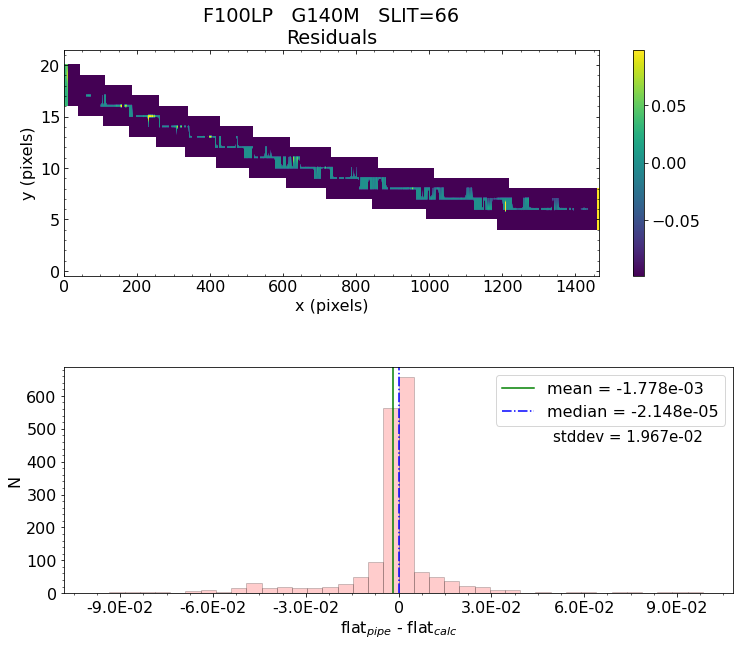

 *** Result of the test: PASSED


Working with slit: 68
 Subwindow origin:   px0=376   py0=1477
silt_id='68'   quad=3   row=334   col=111   slitlet_id='334_111'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = -2.674e-03    median = -1.040e-05    stdev = 1.597e-02
    Maximum   AbsoluteFlat Difference = 9.272e-02
    Minimum   AbsoluteFlat Difference = -9.886e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 48%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 13%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

Making histogram plot for this slitlet...


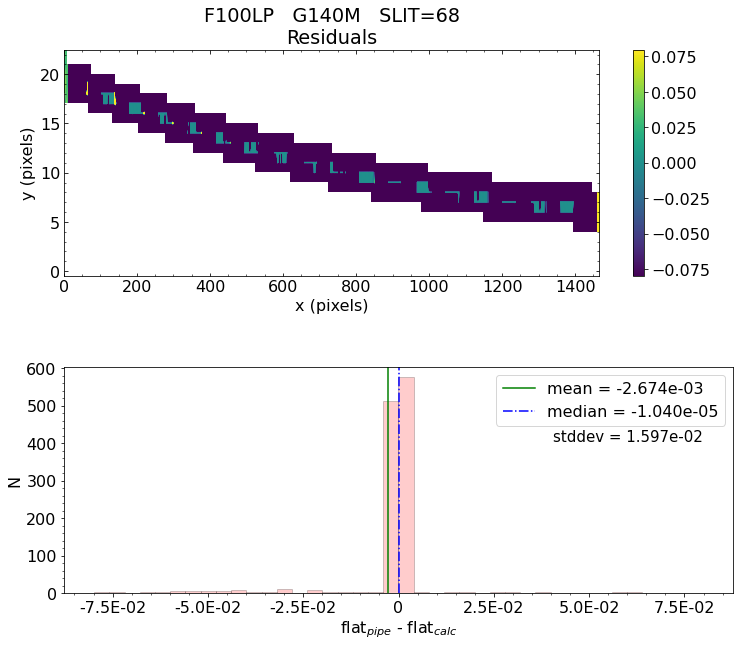

 *** Result of the test: PASSED


Working with slit: 56
 Subwindow origin:   px0=873   py0=769
silt_id='56'   quad=4   row=130   col=12   slitlet_id='130_12'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = 2.185e-03    median = -9.226e-06    stdev = 1.512e-02
    Maximum   AbsoluteFlat Difference = 9.862e-02
    Minimum   AbsoluteFlat Difference = -9.250e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 62%
                            ->  3xtheshold = 34%
                            ->  5xtheshold = 28%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

Making histogram plot for this slitlet...


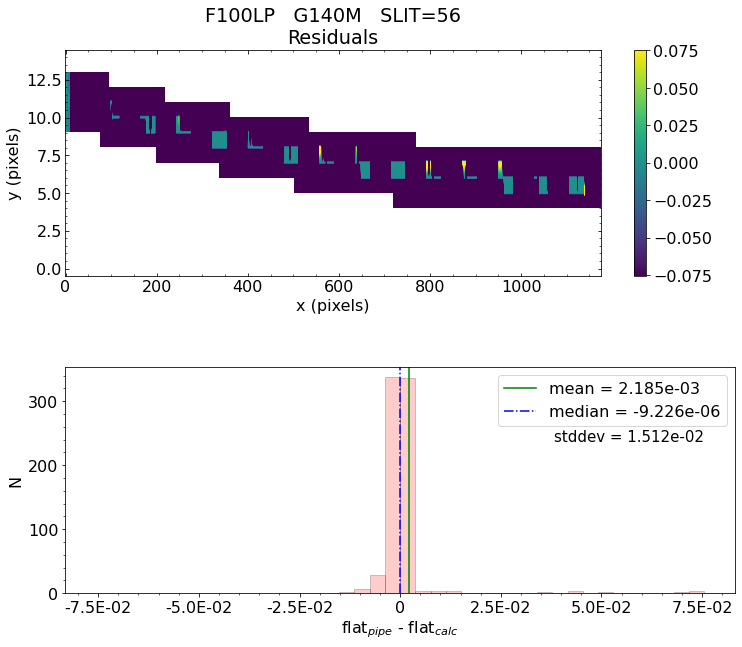

 *** Result of the test: PASSED


Working with slit: 57
 Subwindow origin:   px0=806   py0=355
silt_id='57'   quad=4   row=150   col=94   slitlet_id='150_94'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 
 * Unable to calculate statistics because difference array has all outlier values.
   Test will be set to FAILED and NO plots will be made.
 *** Result of the test: FAILED


Working with slit: 58
 Subwindow origin:   px0=732   py0=259
silt_id='58'   quad=4   row=177   col=113   slitlet_id='177_113'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = -6.802e-04    median = -9.704e-05    stdev = 2.218e-02
    Maximum   AbsoluteFlat Difference = 9.967e-02
    Minimum   AbsoluteFlat Difference = -9.109e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 72%
                            ->  3xtheshold

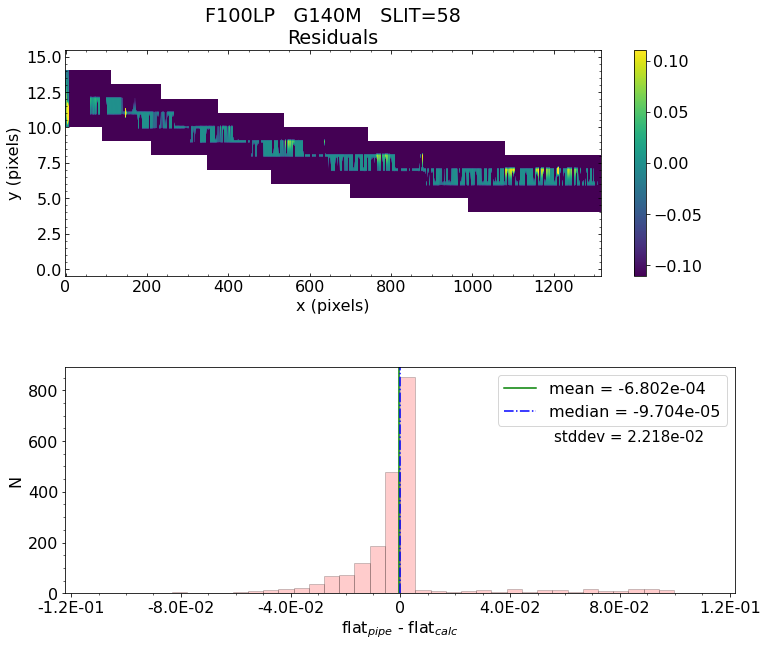

 *** Result of the test: PASSED


Working with slit: 59
 Subwindow origin:   px0=659   py0=72
silt_id='59'   quad=4   row=203   col=150   slitlet_id='203_150'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = 1.653e-03    median = -3.303e-05    stdev = 1.834e-02
    Maximum   AbsoluteFlat Difference = 9.969e-02
    Minimum   AbsoluteFlat Difference = -8.928e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 71%
                            ->  3xtheshold = 52%
                            ->  5xtheshold = 48%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

Making histogram plot for this slitlet...


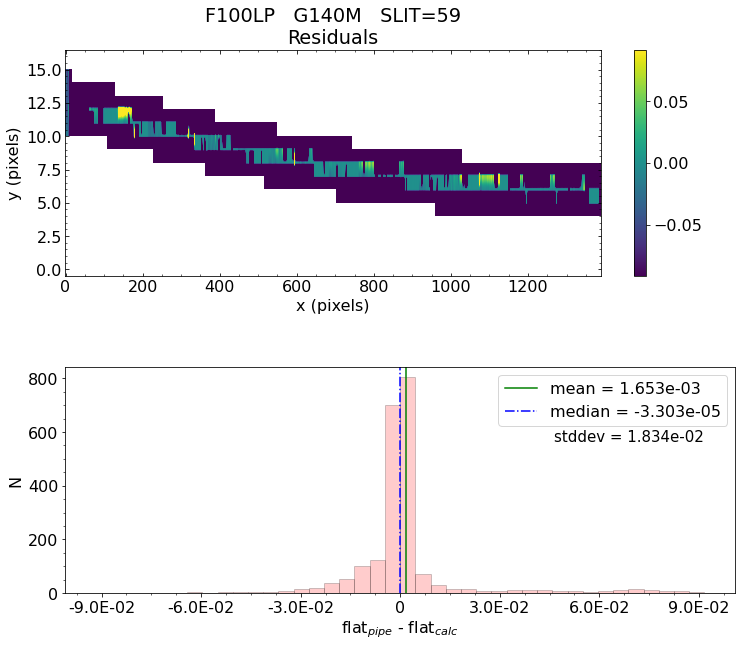

 *** Result of the test: PASSED


Working with slit: 60
 Subwindow origin:   px0=642   py0=682
silt_id='60'   quad=4   row=218   col=29   slitlet_id='218_29'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 
 * Unable to calculate statistics because difference array has all outlier values.
   Test will be set to FAILED and NO plots will be made.
 *** Result of the test: FAILED


Working with slit: 61
 Subwindow origin:   px0=621   py0=823
silt_id='61'   quad=4   row=228   col=1   slitlet_id='228_1'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = 5.571e-03    median = 1.414e-05    stdev = 1.971e-02
    Maximum   AbsoluteFlat Difference = 9.950e-02
    Minimum   AbsoluteFlat Difference = -9.993e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 70%
                            ->  3xtheshold = 51%

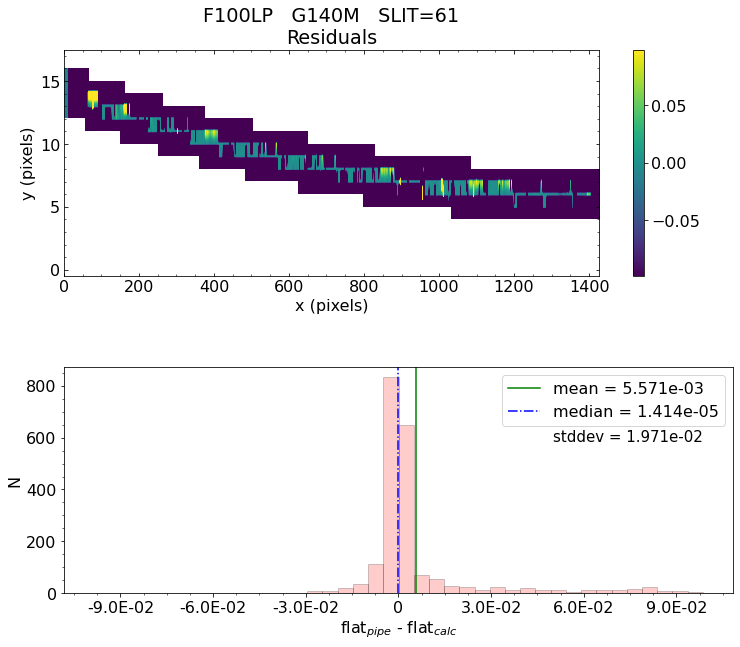

 *** Result of the test: PASSED


Working with slit: 62
 Subwindow origin:   px0=571   py0=511
silt_id='62'   quad=4   row=243   col=63   slitlet_id='243_63'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = 4.445e-03    median = -2.330e-05    stdev = 2.450e-02
    Maximum   AbsoluteFlat Difference = 9.933e-02
    Minimum   AbsoluteFlat Difference = -8.897e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 71%
                            ->  3xtheshold = 49%
                            ->  5xtheshold = 45%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

Making histogram plot for this slitlet...


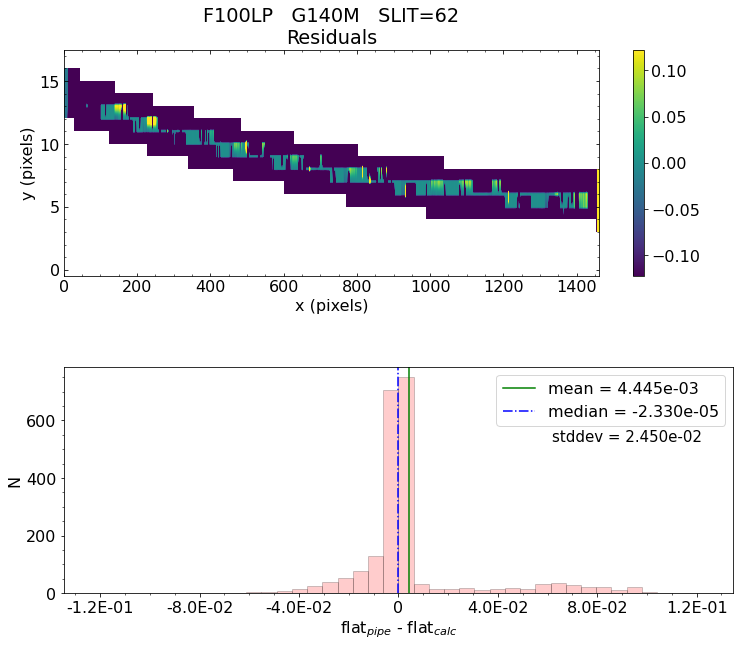

 *** Result of the test: PASSED


Working with slit: 63
 Subwindow origin:   px0=455   py0=182
silt_id='63'   quad=4   row=283   col=128   slitlet_id='283_128'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = 5.488e-03    median = -2.261e-05    stdev = 2.551e-02
    Maximum   AbsoluteFlat Difference = 9.933e-02
    Minimum   AbsoluteFlat Difference = -8.449e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 72%
                            ->  3xtheshold = 52%
                            ->  5xtheshold = 47%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

Making histogram plot for this slitlet...


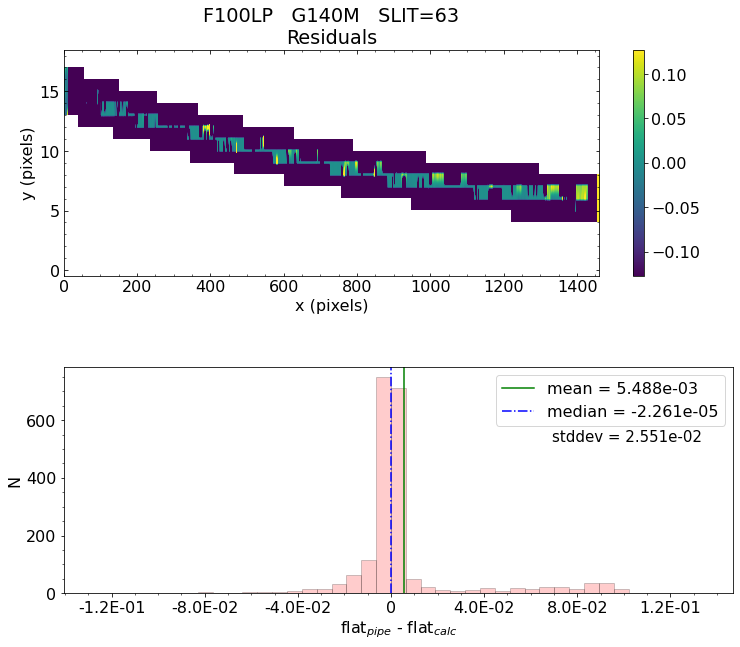

 *** Result of the test: PASSED


Working with slit: 64
 Subwindow origin:   px0=455   py0=177
silt_id='64'   quad=4   row=283   col=129   slitlet_id='283_129'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = 4.705e-03    median = -2.897e-05    stdev = 2.462e-02
    Maximum   AbsoluteFlat Difference = 9.871e-02
    Minimum   AbsoluteFlat Difference = -9.589e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 72%
                            ->  3xtheshold = 52%
                            ->  5xtheshold = 48%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

Making histogram plot for this slitlet...


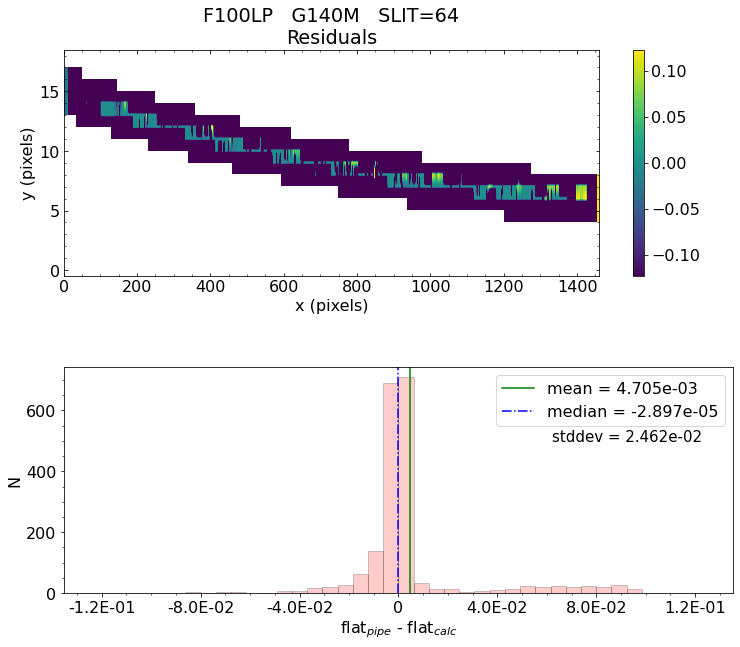

 *** Result of the test: PASSED


Working with slit: 67
 Subwindow origin:   px0=329   py0=131
silt_id='67'   quad=4   row=331   col=138   slitlet_id='331_138'
Now looping through the pixels, this will take a while ... 
Calculating statistics... 

   Absolute Flat Difference  :   mean = 1.145e-02    median = 4.049e-05    stdev = 2.873e-02
    Maximum   AbsoluteFlat Difference = 9.970e-02
    Minimum   AbsoluteFlat Difference = -9.907e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 72%
                            ->  3xtheshold = 53%
                            ->  5xtheshold = 48%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

Making histogram plot for this slitlet...


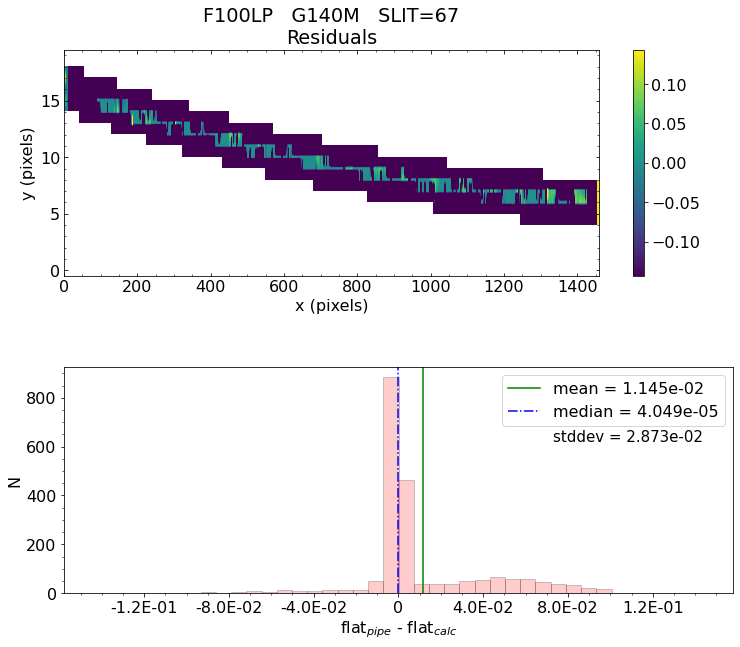

 *** Result of the test: PASSED


 *** Final result for flat_field test will be reported as FAILED *** 

('* Script flattest_mos.py took ', '1.460542896323734 hours to finish.')


In [5]:
# Run the validation test
%matplotlib inline
result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.flattest_mos.flattest(pipe_result,
                                                                                               dflat_path=dflat_path,
                                                                                               sflat_path=sflat_path, 
                                                                                               fflat_path=fflat_path,
                                                                                               msa_shutter_conf=msa_shutter_conf,     
                                                                                               writefile=writefile,
                                                                                               show_figs=show_figs, 
                                                                                               save_figs=save_figs,
                                                                                               plot_name=None,
                                                                                               threshold_diff=threshold_diff,
                                                                                               debug=False)


In [6]:
# Quickly see if the test passed 
   
print("Did flat_field validation for MOS test passed? ", result_msg)


Did flat_field validation for MOS test passed?  One or more slitlets FAILED flat_field test.


<a id="IFU"></a>
# IFU test

In [12]:
# Set the variables 
output_directory = '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/IFU_CV3/G395H_OPAQUE'
input_file = 'final_output_caldet1_NRS2_assign_wcs.fits'   # IFU does not do the extract_2d step
input_file = os.path.join(output_directory, input_file)
dflat_path = '/grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.2_D_Flat/nirspec_dflat'
sflat_path = '/grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.3_S_Flat/IFU/nirspec_IFU_sflat'
fflat_path = '/grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.1_F_Flat/IFU/nirspec_IFU_fflat'
writefile = False
save_figs = False
show_figs = True
threshold_diff = 9.999e-5

In [13]:
# Run the pipeline step
pipe_result = input_file.replace("assign_wcs.fits", "flat_field.fits")
FlatFieldStep.call(input_file, output_file=pipe_result, save_interpolated_flat=True)

# Move the output files to the output directory
subprocess.run(['mv', os.path.basename(input_file).replace('assign_wcs.fits', 'flatfieldstep.fits'), pipe_result])
interpolated_flat = input_file.replace("assign_wcs.fits", "interpolatedflat.fits")
subprocess.run(['mv', os.path.basename(input_file).replace('assign_wcs.fits', 'interpolatedflat.fits'), interpolated_flat])


2020-05-07 13:09:26,958 - CRDS - ERROR -  Error determining best reference for 'pars-flatfieldstep'  =   Unknown reference type 'pars-flatfieldstep'
2020-05-07 13:09:26,961 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2020-05-07 13:09:27,315 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args ('/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/IFU_CV3/G395H_OPAQUE/final_output_caldet1_NRS2_assign_wcs.fits',).
2020-05-07 13:09:27,316 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/IFU_CV3/G395H_OPAQUE/final_output_caldet1_NRS2_flat_field.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': True}
2020-05-07 13:17:33,207 - stpi

CompletedProcess(args=['mv', 'final_output_caldet1_NRS2_interpolatedflat.fits', '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/IFU_CV3/G395H_OPAQUE/final_output_caldet1_NRS2_interpolatedflat.fits'], returncode=0)

step_input_filename=/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/IFU_CV3/G395H_OPAQUE/final_output_caldet1_NRS2_flat_field.fits
flat_field_file  -->     Grating:G395H   Filter:F290LP   EXP_TYPE:NRS_IFU
Getting and reading the D-, S-, and F-flats for this specific IFU configuration... 
Using D-flat: /grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.2_D_Flat/nirspec_dflat_nrs2_f_01.03.fits
Using S-flat: /grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.3_S_Flat/IFU/nirspec_IFU_sflat_G395H_OPAQUE_FLAT3_nrs2_f_01.01.fits
Using F-flat: /grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.1_F_Flat/IFU/nirspec_IFU_fflat_F290LP_01.01.fits

 Now looping through the slices, this may take some time... 

Working with slice: 00
 Subwindow origin:   px0=1   py0=781
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 00

   Absolute Flat Difference  :   mean = 2.168e-08    median = 6.346e-08    stdev = 6.939e-05
    Maximum   AbsoluteFlat Differ

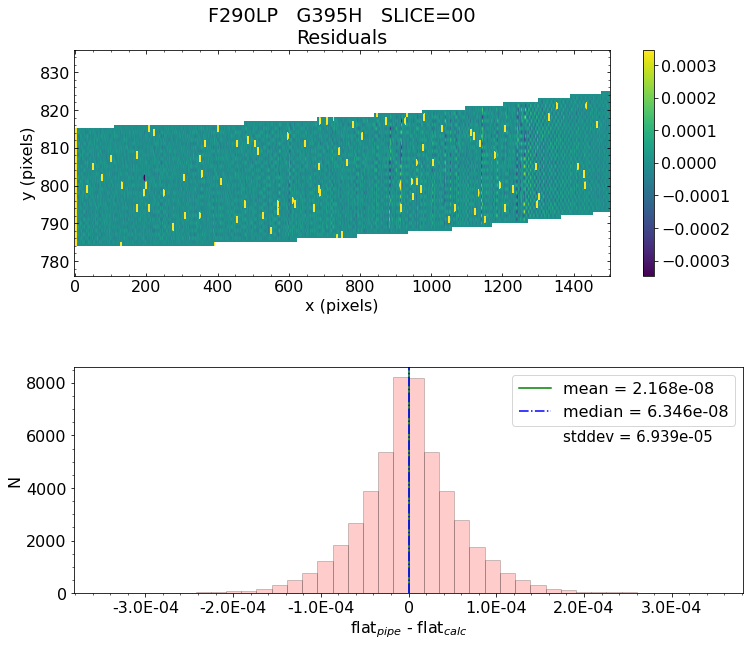

 *** Result of the test: PASSED


Working with slice: 01
 Subwindow origin:   px0=1   py0=1197
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 01

   Absolute Flat Difference  :   mean = -6.246e-08    median = -3.189e-08    stdev = 6.755e-05
    Maximum   AbsoluteFlat Difference = 8.549e-04
    Minimum   AbsoluteFlat Difference = -8.739e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 11%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


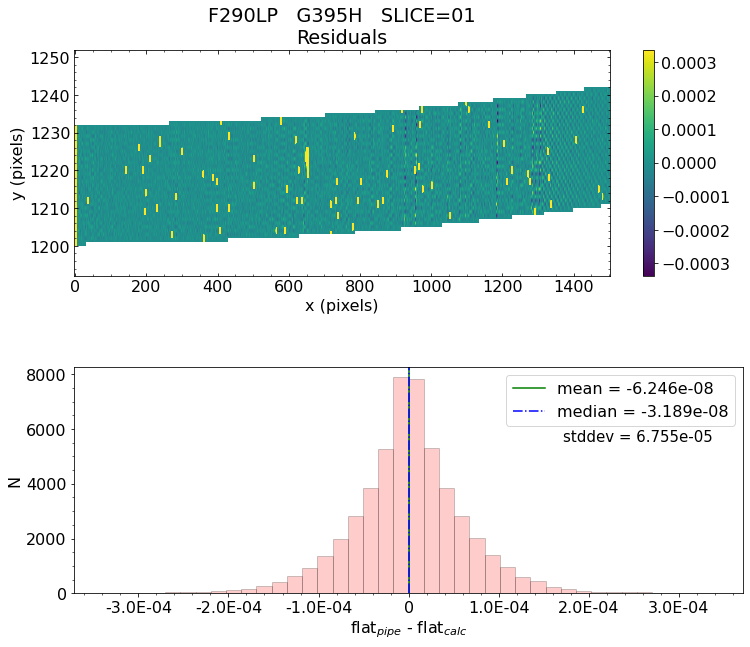

 *** Result of the test: PASSED


Working with slice: 02
 Subwindow origin:   px0=1   py0=731
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 02

   Absolute Flat Difference  :   mean = 1.348e-08    median = 3.126e-08    stdev = 6.590e-05
    Maximum   AbsoluteFlat Difference = 8.870e-04
    Minimum   AbsoluteFlat Difference = -6.725e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


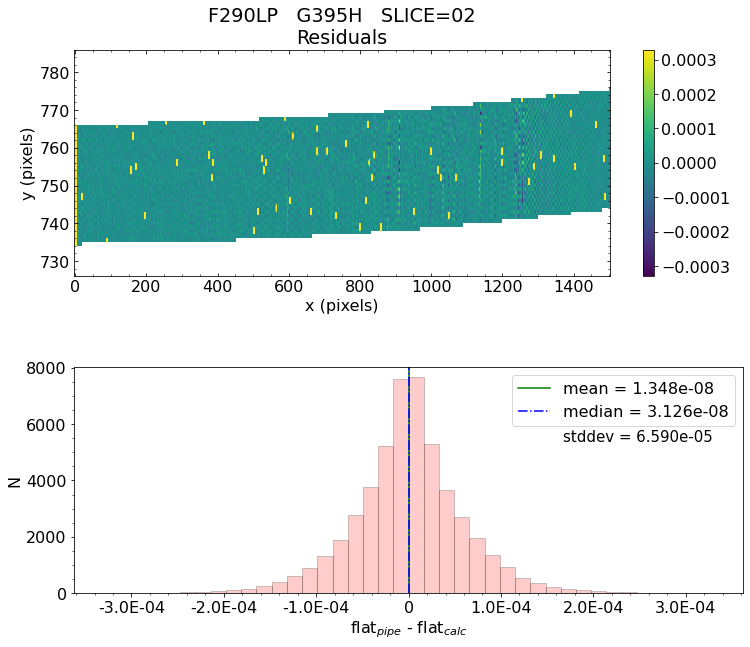

 *** Result of the test: PASSED


Working with slice: 03
 Subwindow origin:   px0=1   py0=1247
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 03

   Absolute Flat Difference  :   mean = -3.159e-08    median = 9.957e-08    stdev = 6.616e-05
    Maximum   AbsoluteFlat Difference = 9.555e-04
    Minimum   AbsoluteFlat Difference = -8.231e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 11%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


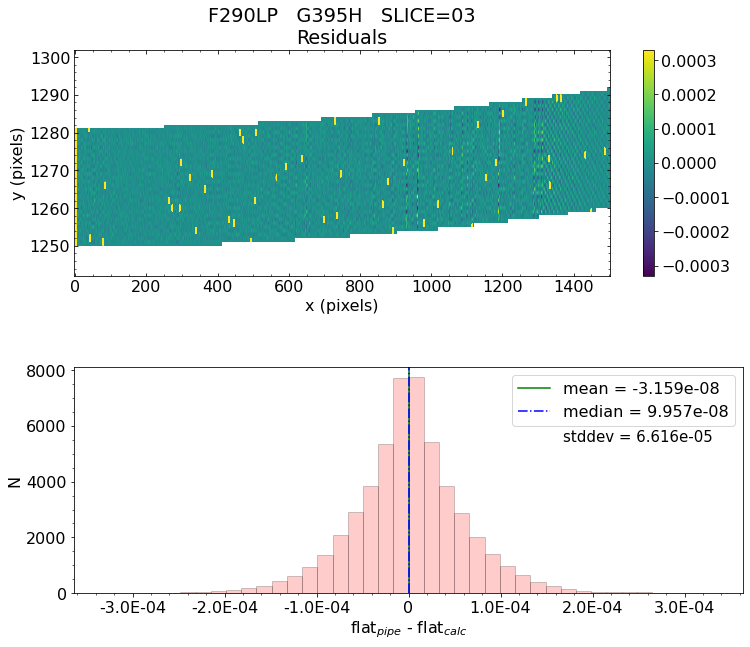

 *** Result of the test: PASSED


Working with slice: 04
 Subwindow origin:   px0=1   py0=682
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 04

   Absolute Flat Difference  :   mean = -1.194e-07    median = 3.553e-09    stdev = 6.698e-05
    Maximum   AbsoluteFlat Difference = 7.617e-04
    Minimum   AbsoluteFlat Difference = -7.885e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 11%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


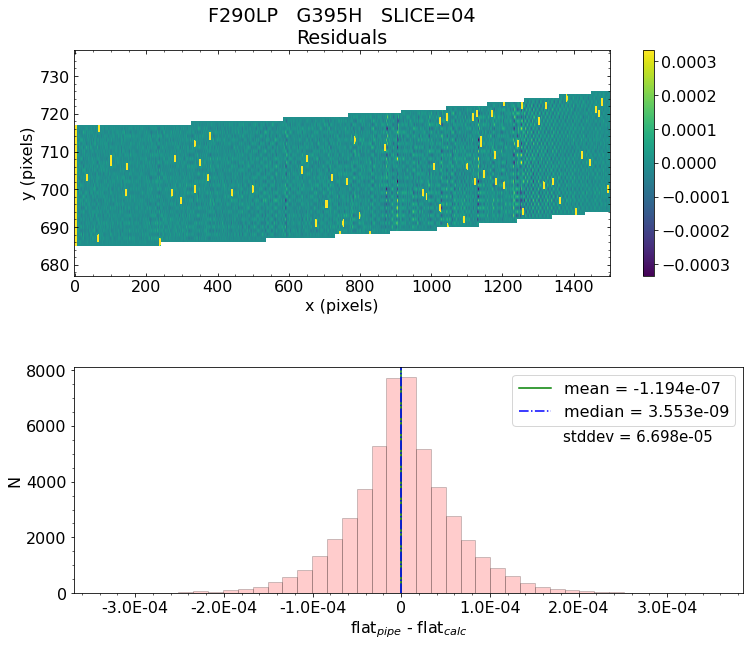

 *** Result of the test: PASSED


Working with slice: 05
 Subwindow origin:   px0=1   py0=1296
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 05

   Absolute Flat Difference  :   mean = -5.244e-08    median = 5.983e-08    stdev = 6.545e-05
    Maximum   AbsoluteFlat Difference = 8.285e-04
    Minimum   AbsoluteFlat Difference = -8.851e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


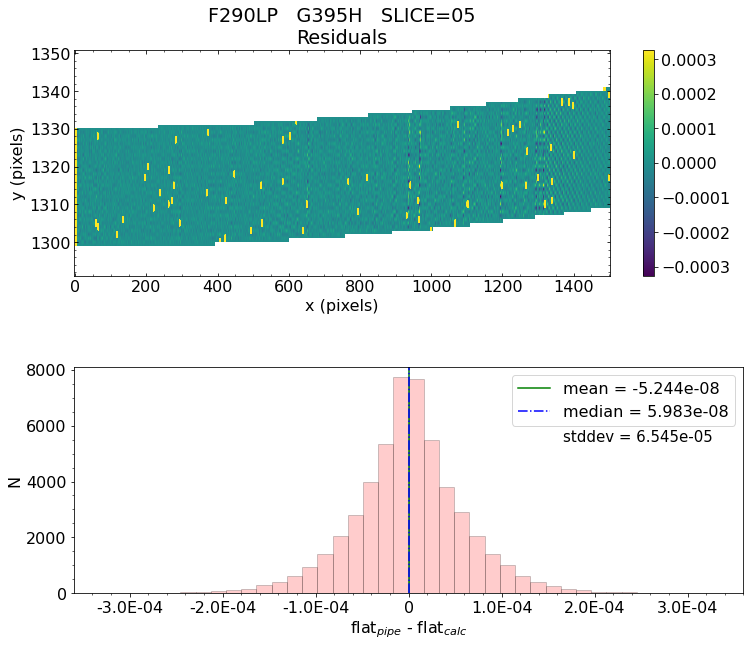

 *** Result of the test: PASSED


Working with slice: 06
 Subwindow origin:   px0=1   py0=633
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 06

   Absolute Flat Difference  :   mean = 6.762e-08    median = 1.477e-08    stdev = 6.570e-05
    Maximum   AbsoluteFlat Difference = 8.919e-04
    Minimum   AbsoluteFlat Difference = -8.686e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


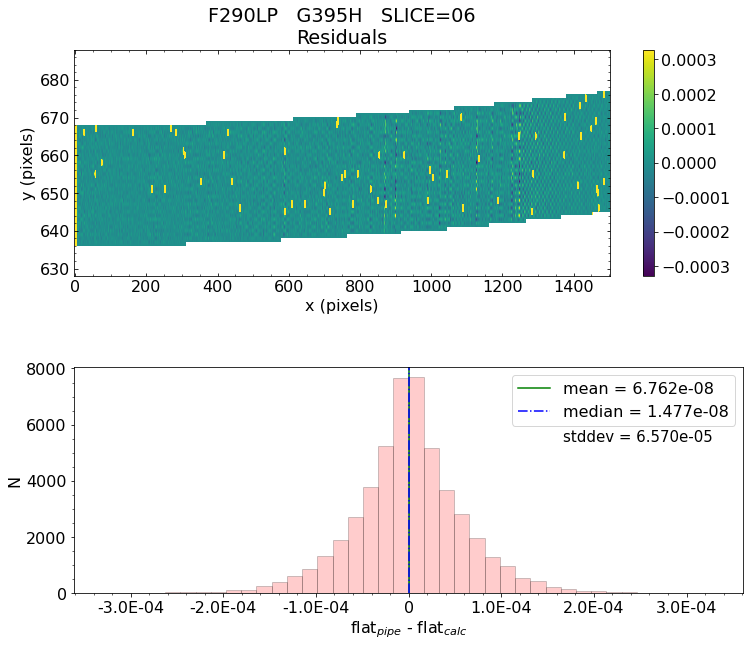

 *** Result of the test: PASSED


Working with slice: 07
 Subwindow origin:   px0=1   py0=1345
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 07

   Absolute Flat Difference  :   mean = -8.432e-08    median = 6.254e-08    stdev = 6.567e-05
    Maximum   AbsoluteFlat Difference = 8.171e-04
    Minimum   AbsoluteFlat Difference = -7.579e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


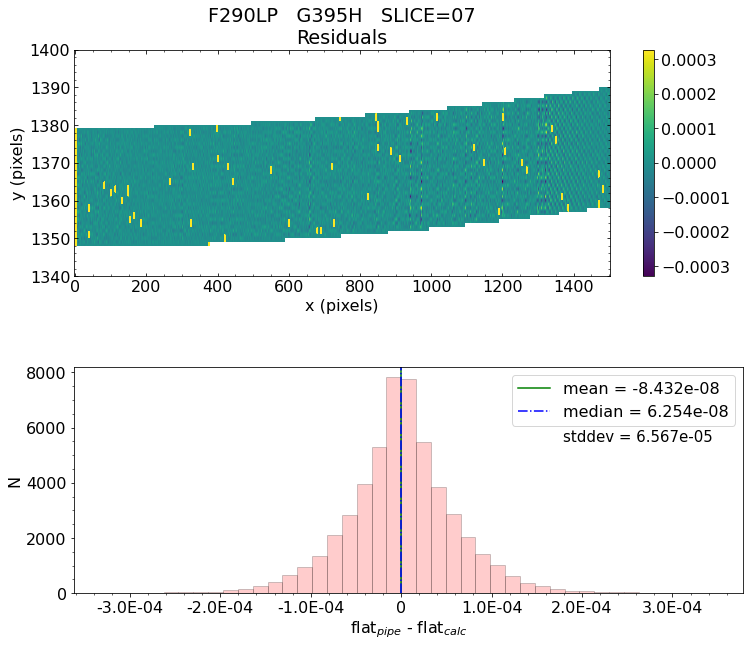

 *** Result of the test: PASSED


Working with slice: 08
 Subwindow origin:   px0=1   py0=584
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 08

   Absolute Flat Difference  :   mean = 7.427e-08    median = -8.539e-08    stdev = 6.572e-05
    Maximum   AbsoluteFlat Difference = 8.631e-04
    Minimum   AbsoluteFlat Difference = -8.838e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


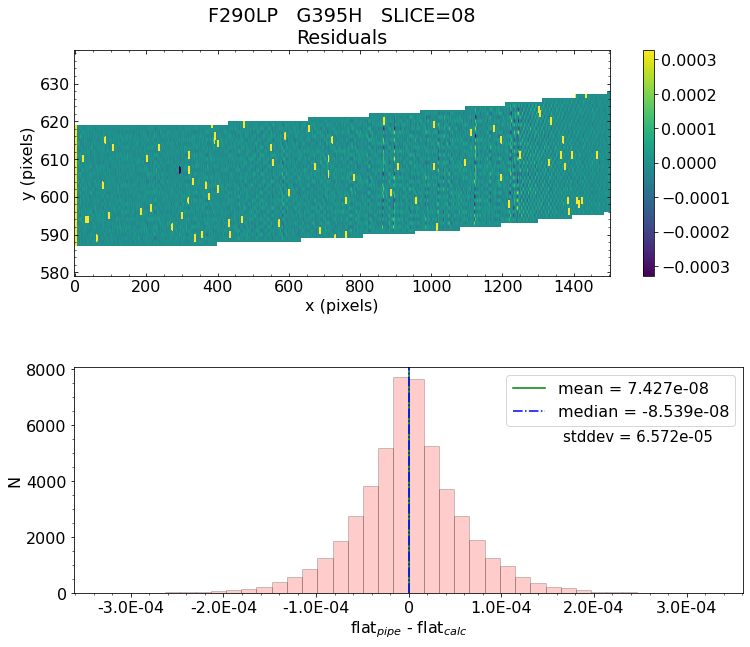

 *** Result of the test: PASSED


Working with slice: 09
 Subwindow origin:   px0=1   py0=1394
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 09

   Absolute Flat Difference  :   mean = -6.399e-08    median = 1.396e-07    stdev = 6.595e-05
    Maximum   AbsoluteFlat Difference = 8.630e-04
    Minimum   AbsoluteFlat Difference = -8.051e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


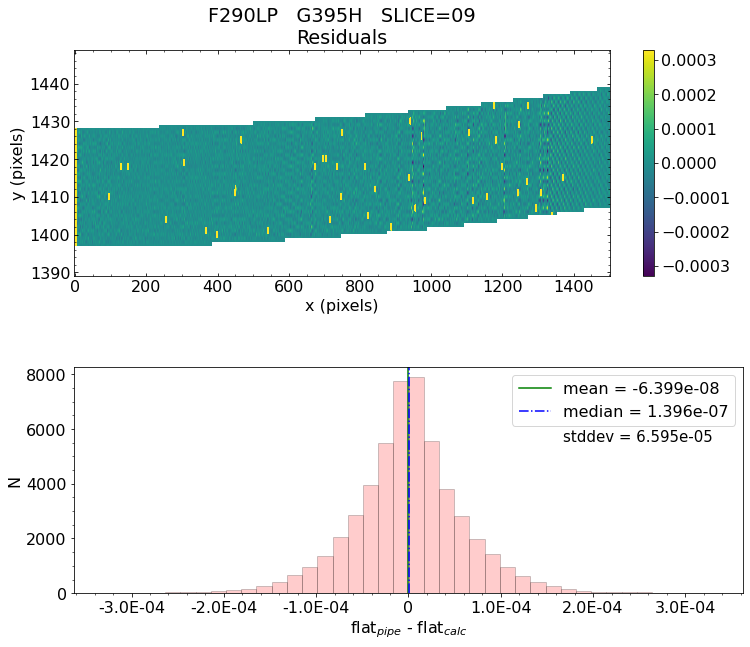

 *** Result of the test: PASSED


Working with slice: 10
 Subwindow origin:   px0=1   py0=534
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 10

   Absolute Flat Difference  :   mean = 3.099e-08    median = 1.684e-08    stdev = 6.553e-05
    Maximum   AbsoluteFlat Difference = 8.349e-04
    Minimum   AbsoluteFlat Difference = -9.347e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


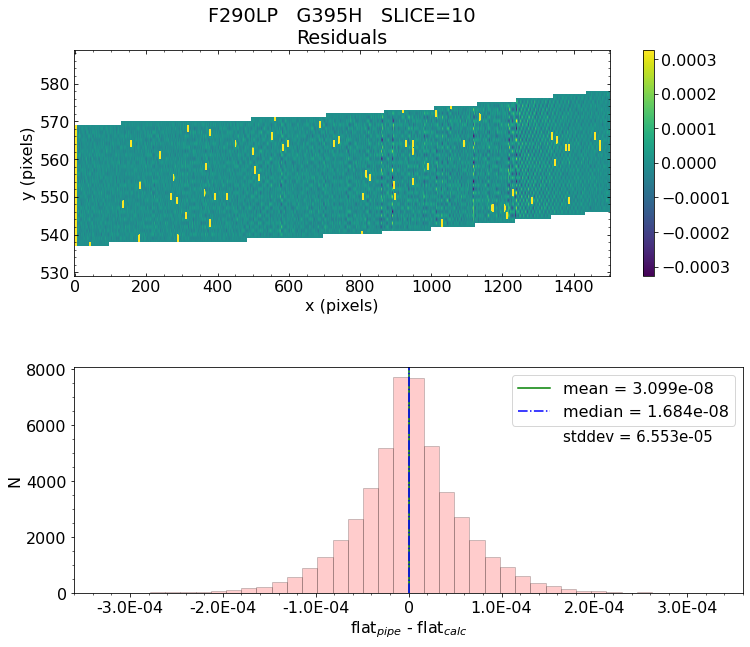

 *** Result of the test: PASSED


Working with slice: 11
 Subwindow origin:   px0=1   py0=1443
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 11

   Absolute Flat Difference  :   mean = -1.799e-07    median = -2.454e-07    stdev = 6.592e-05
    Maximum   AbsoluteFlat Difference = 8.642e-04
    Minimum   AbsoluteFlat Difference = -9.221e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


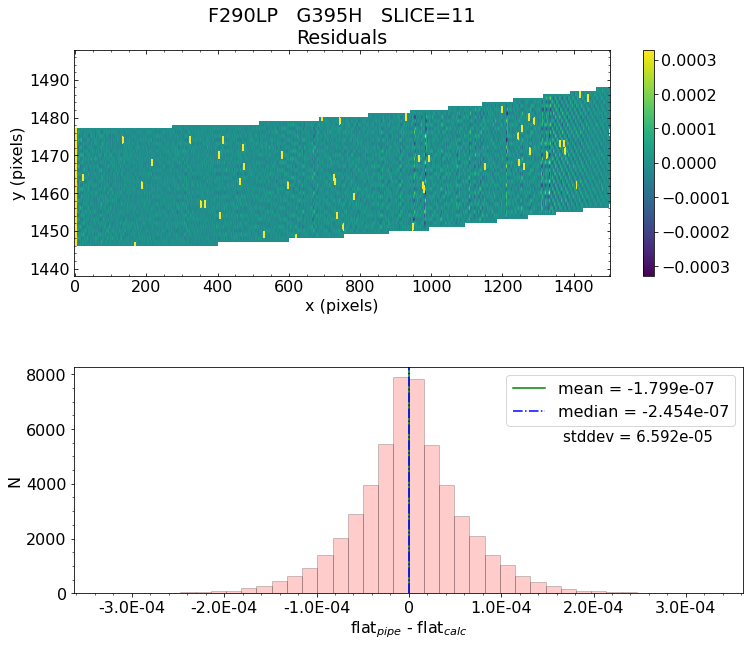

 *** Result of the test: PASSED


Working with slice: 12
 Subwindow origin:   px0=1   py0=485
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 12

   Absolute Flat Difference  :   mean = -5.865e-08    median = 6.309e-08    stdev = 6.552e-05
    Maximum   AbsoluteFlat Difference = 8.789e-04
    Minimum   AbsoluteFlat Difference = -1.459e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


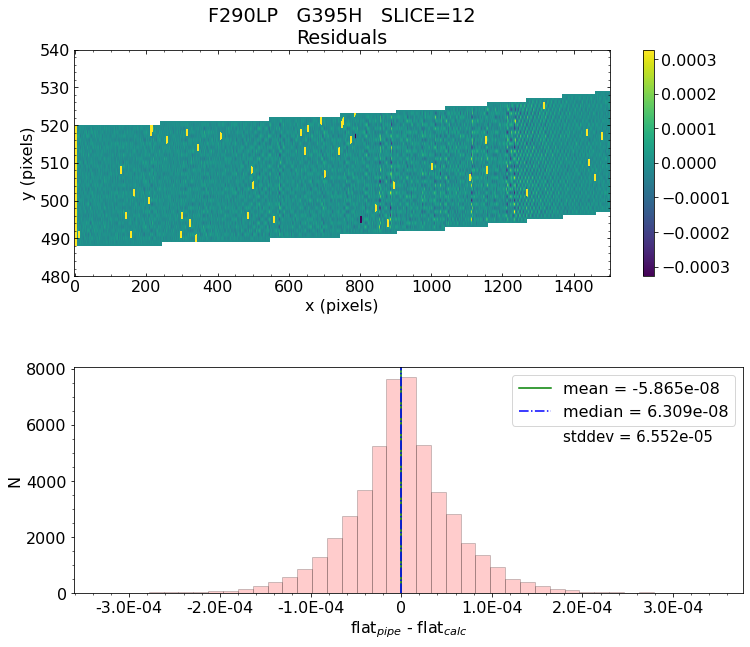

 *** Result of the test: PASSED


Working with slice: 13
 Subwindow origin:   px0=1   py0=1491
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 13

   Absolute Flat Difference  :   mean = -2.238e-08    median = 1.063e-07    stdev = 6.566e-05
    Maximum   AbsoluteFlat Difference = 8.500e-04
    Minimum   AbsoluteFlat Difference = -8.229e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 11%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


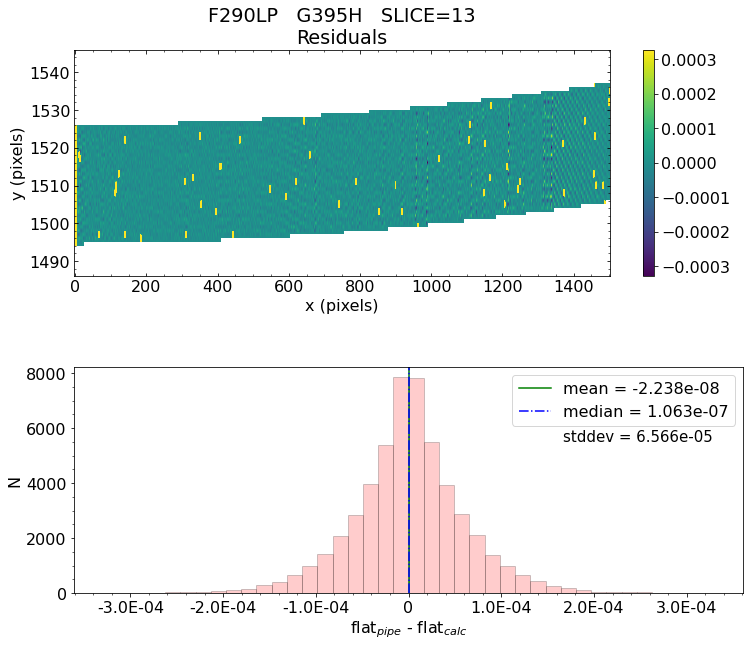

 *** Result of the test: PASSED


Working with slice: 14
 Subwindow origin:   px0=1   py0=436
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 14

   Absolute Flat Difference  :   mean = 1.212e-07    median = 1.695e-07    stdev = 6.529e-05
    Maximum   AbsoluteFlat Difference = 9.252e-04
    Minimum   AbsoluteFlat Difference = -8.729e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


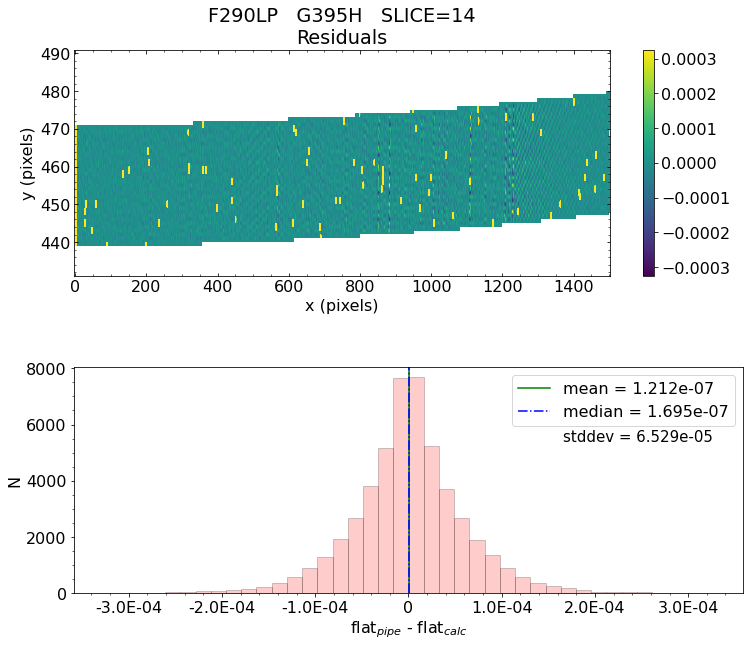

 *** Result of the test: PASSED


Working with slice: 15
 Subwindow origin:   px0=1   py0=1540
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 15

   Absolute Flat Difference  :   mean = -8.724e-08    median = 4.949e-08    stdev = 6.587e-05
    Maximum   AbsoluteFlat Difference = 7.416e-04
    Minimum   AbsoluteFlat Difference = -8.280e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


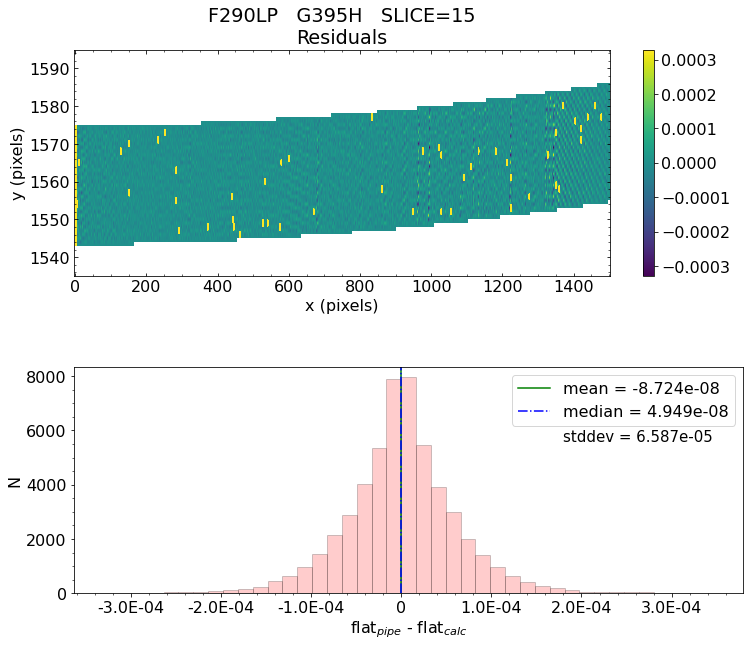

 *** Result of the test: PASSED


Working with slice: 16
 Subwindow origin:   px0=1   py0=387
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 16

   Absolute Flat Difference  :   mean = 7.301e-09    median = 1.442e-07    stdev = 6.518e-05
    Maximum   AbsoluteFlat Difference = 9.374e-04
    Minimum   AbsoluteFlat Difference = -9.005e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


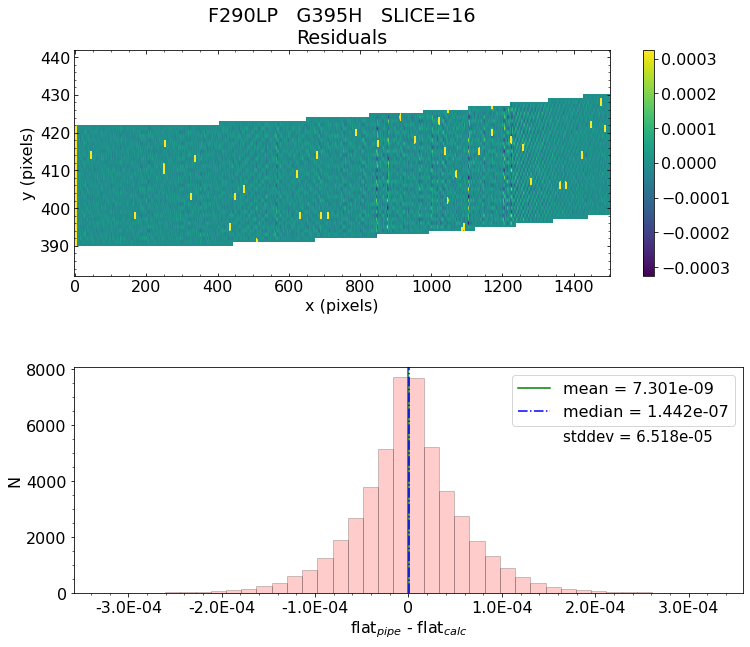

 *** Result of the test: PASSED


Working with slice: 17
 Subwindow origin:   px0=1   py0=1589
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 17

   Absolute Flat Difference  :   mean = 2.076e-07    median = -1.157e-09    stdev = 6.630e-05
    Maximum   AbsoluteFlat Difference = 7.847e-04
    Minimum   AbsoluteFlat Difference = -7.677e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 11%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


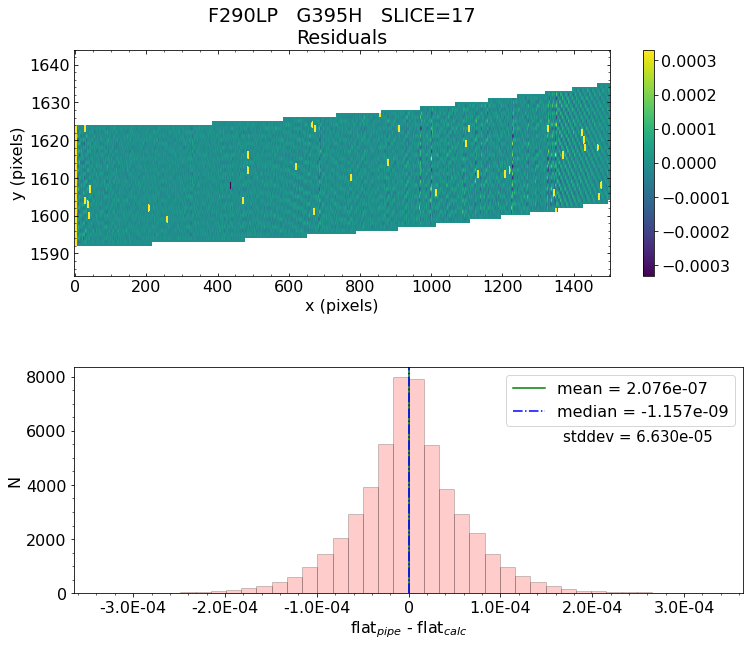

 *** Result of the test: PASSED


Working with slice: 18
 Subwindow origin:   px0=1   py0=337
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 18

   Absolute Flat Difference  :   mean = -1.832e-07    median = 7.087e-08    stdev = 6.453e-05
    Maximum   AbsoluteFlat Difference = 8.030e-04
    Minimum   AbsoluteFlat Difference = -9.155e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


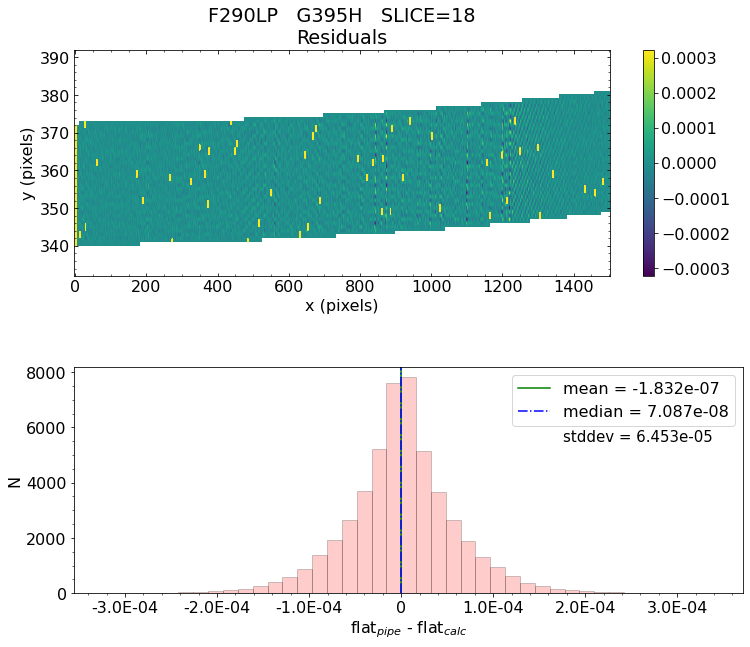

 *** Result of the test: PASSED


Working with slice: 19
 Subwindow origin:   px0=1   py0=1638
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 19

   Absolute Flat Difference  :   mean = -2.059e-07    median = -1.496e-08    stdev = 6.755e-05
    Maximum   AbsoluteFlat Difference = 7.233e-04
    Minimum   AbsoluteFlat Difference = -9.334e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 11%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


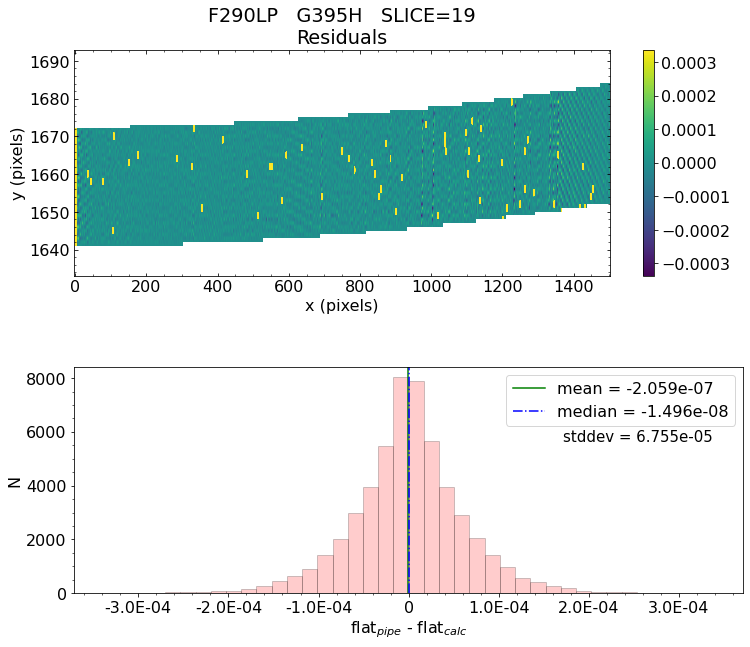

 *** Result of the test: PASSED


Working with slice: 20
 Subwindow origin:   px0=1   py0=288
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 20

   Absolute Flat Difference  :   mean = 1.760e-08    median = 2.096e-07    stdev = 6.376e-05
    Maximum   AbsoluteFlat Difference = 8.165e-04
    Minimum   AbsoluteFlat Difference = -8.683e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


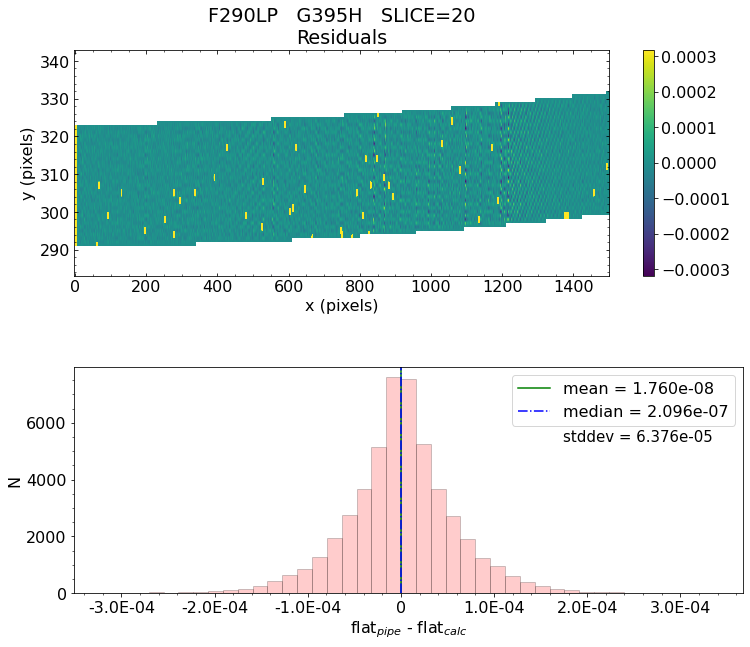

 *** Result of the test: PASSED


Working with slice: 21
 Subwindow origin:   px0=1   py0=1687
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 21

   Absolute Flat Difference  :   mean = 2.248e-08    median = -4.151e-09    stdev = 6.668e-05
    Maximum   AbsoluteFlat Difference = 8.358e-04
    Minimum   AbsoluteFlat Difference = -8.637e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 11%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


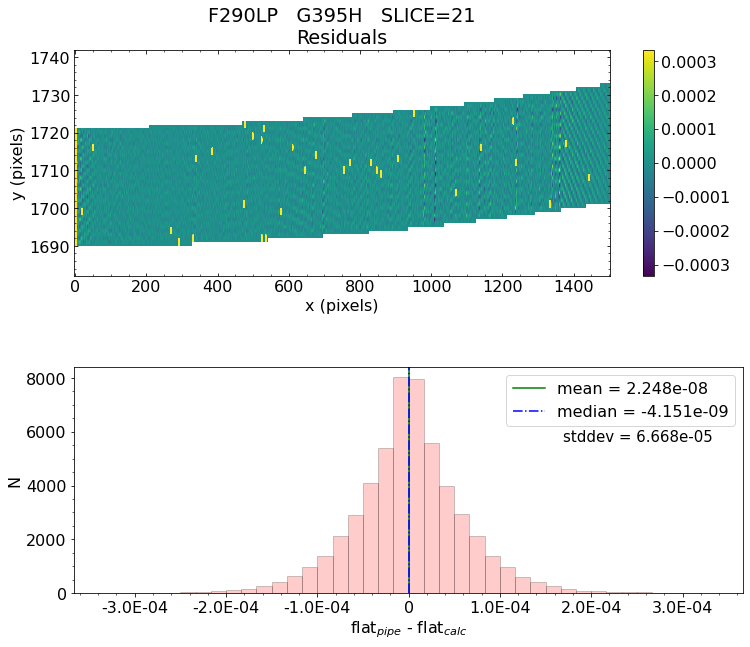

 *** Result of the test: PASSED


Working with slice: 22
 Subwindow origin:   px0=1   py0=239
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 22

   Absolute Flat Difference  :   mean = -1.710e-07    median = 9.461e-08    stdev = 6.571e-05
    Maximum   AbsoluteFlat Difference = 7.390e-04
    Minimum   AbsoluteFlat Difference = -9.306e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


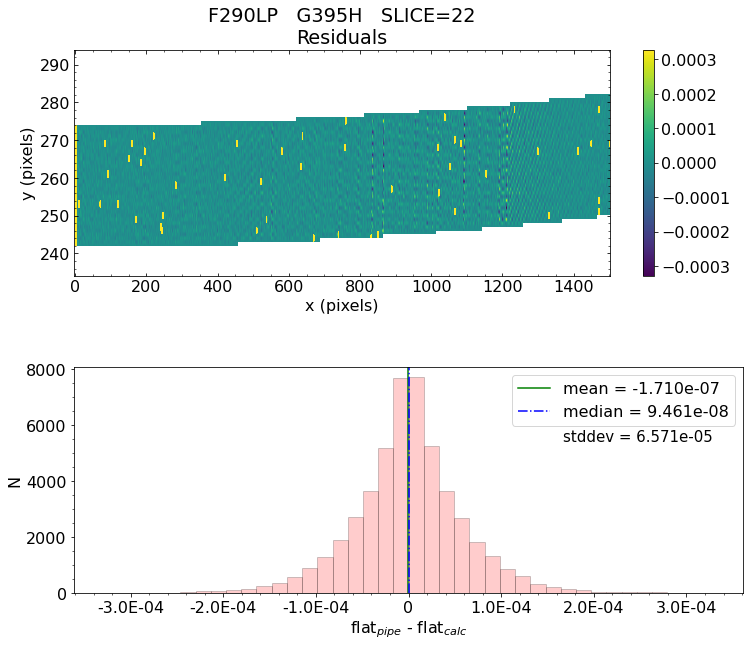

 *** Result of the test: PASSED


Working with slice: 23
 Subwindow origin:   px0=1   py0=1736
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 23

   Absolute Flat Difference  :   mean = 2.661e-07    median = 1.713e-07    stdev = 6.725e-05
    Maximum   AbsoluteFlat Difference = 8.318e-04
    Minimum   AbsoluteFlat Difference = -8.463e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 11%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


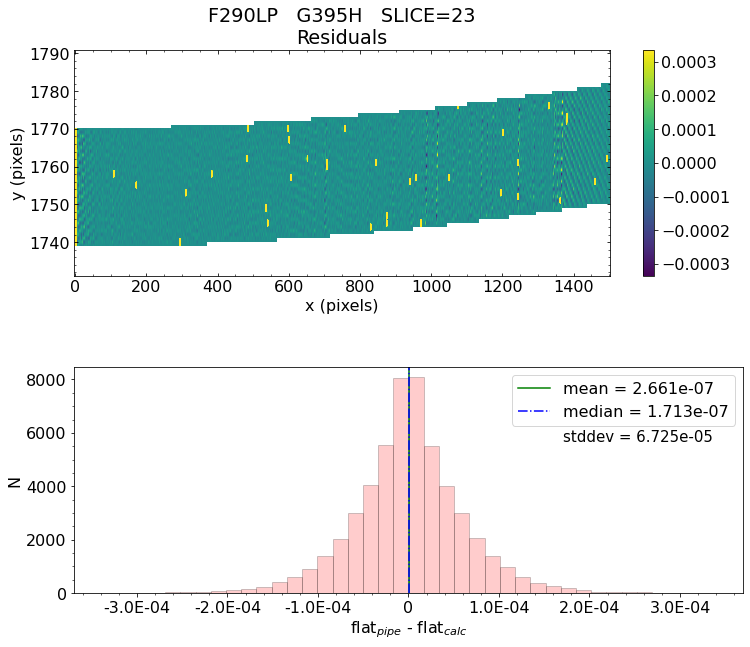

 *** Result of the test: PASSED


Working with slice: 24
 Subwindow origin:   px0=1   py0=189
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 24

   Absolute Flat Difference  :   mean = -2.886e-09    median = 1.421e-07    stdev = 6.573e-05
    Maximum   AbsoluteFlat Difference = 8.327e-04
    Minimum   AbsoluteFlat Difference = -8.911e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


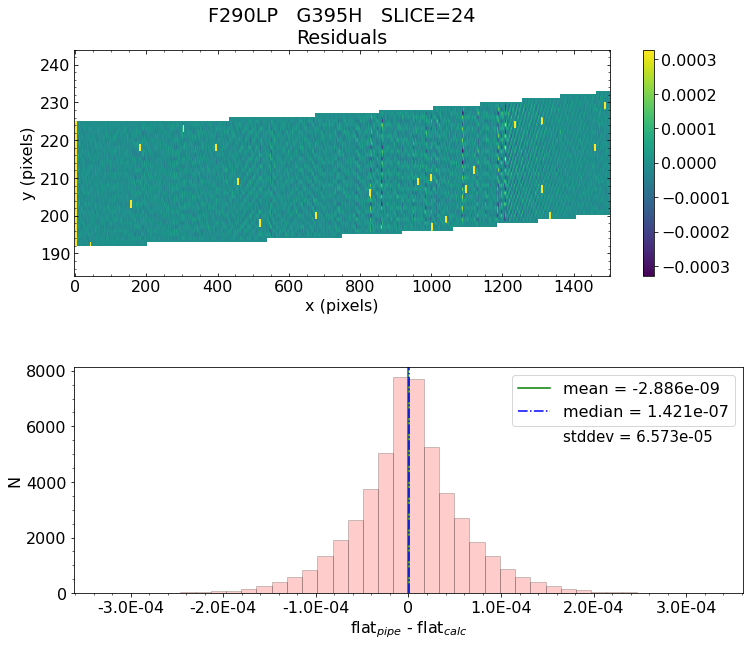

 *** Result of the test: PASSED


Working with slice: 25
 Subwindow origin:   px0=1   py0=1784
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 25

   Absolute Flat Difference  :   mean = -7.253e-08    median = 1.034e-07    stdev = 6.775e-05
    Maximum   AbsoluteFlat Difference = 8.188e-04
    Minimum   AbsoluteFlat Difference = -8.996e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 11%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


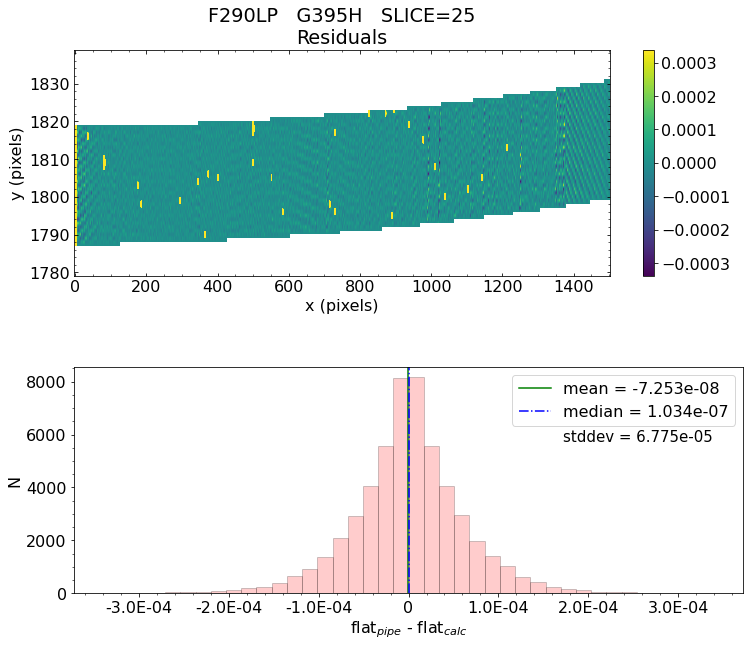

 *** Result of the test: PASSED


Working with slice: 26
 Subwindow origin:   px0=1   py0=140
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 26

   Absolute Flat Difference  :   mean = 1.225e-07    median = 3.557e-08    stdev = 6.578e-05
    Maximum   AbsoluteFlat Difference = 8.011e-04
    Minimum   AbsoluteFlat Difference = -8.995e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 10%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


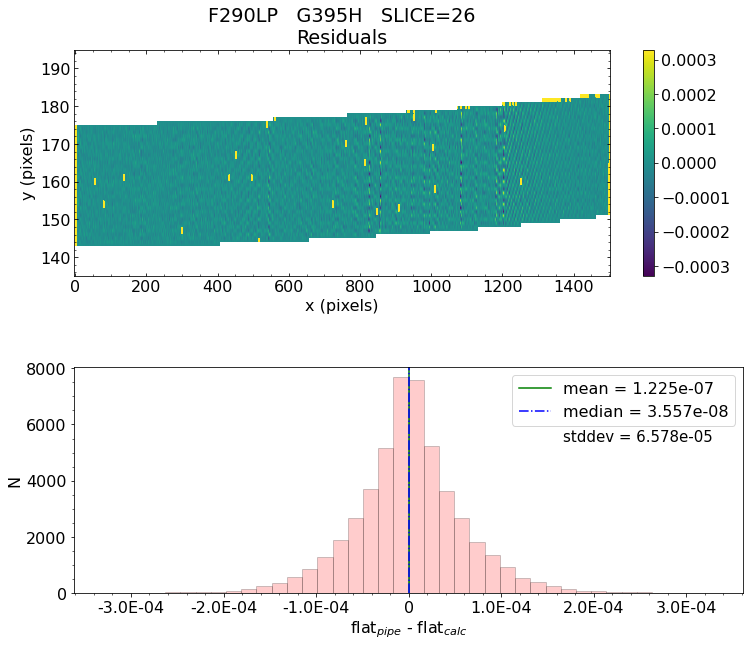

 *** Result of the test: PASSED


Working with slice: 27
 Subwindow origin:   px0=1   py0=1833
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 27

   Absolute Flat Difference  :   mean = -7.991e-08    median = 1.957e-07    stdev = 7.064e-05
    Maximum   AbsoluteFlat Difference = 1.263e-03
    Minimum   AbsoluteFlat Difference = -1.566e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 11%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


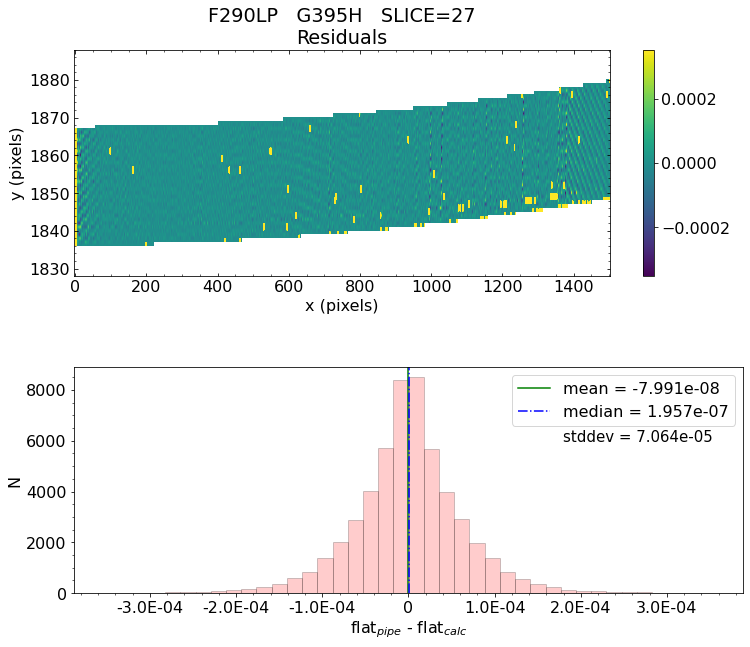

 *** Result of the test: PASSED


Working with slice: 28
 Subwindow origin:   px0=1   py0=90
 Looping through the wavelngth, this may take a little time ... 
Flat value differences for slice number: 28

   Absolute Flat Difference  :   mean = -7.503e-08    median = 1.017e-07    stdev = 5.715e-05
    Maximum   AbsoluteFlat Difference = 6.428e-04
    Minimum   AbsoluteFlat Difference = -7.690e-04
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 7%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Making the plot for this slice...


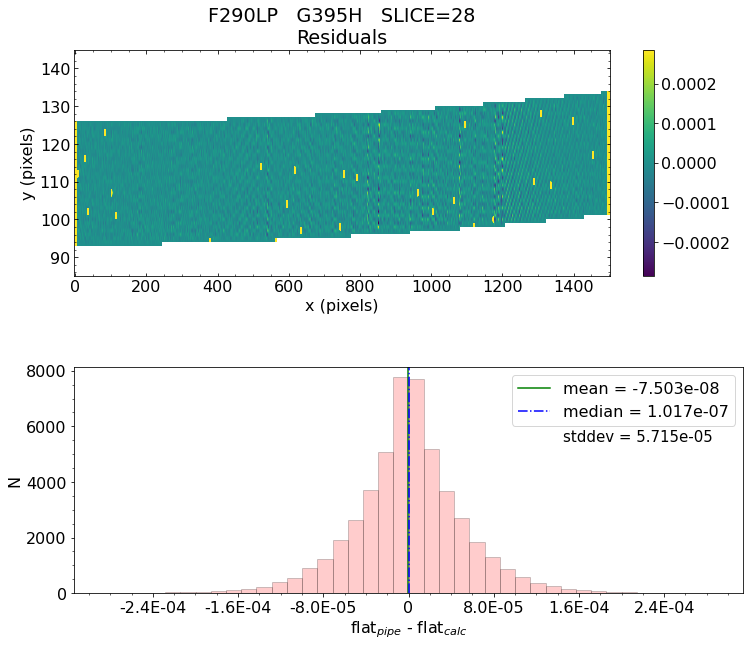

 *** Result of the test: PASSED


Working with slice: 29
 Subwindow origin:   px0=1   py0=1882
 Looping through the wavelngth, this may take a little time ... 


2020-05-07 14:15:45,026 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/flattest_ifu.py:488: RuntimeWarning: invalid value encountered in less
  log_msgs.append(msg)

2020-05-07 14:15:45,031 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/flattest_ifu.py:488: RuntimeWarning: invalid value encountered in greater
  log_msgs.append(msg)



Flat value differences for slice number: 29

   Absolute Flat Difference  :   mean = 3.974e-07    median = 2.696e-07    stdev = 9.526e-05
    Maximum   AbsoluteFlat Difference = 1.397e-02
    Minimum   AbsoluteFlat Difference = -1.484e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 11%
                            ->  3xtheshold = 1%
                            ->  5xtheshold = 0%
Making the plot for this slice...


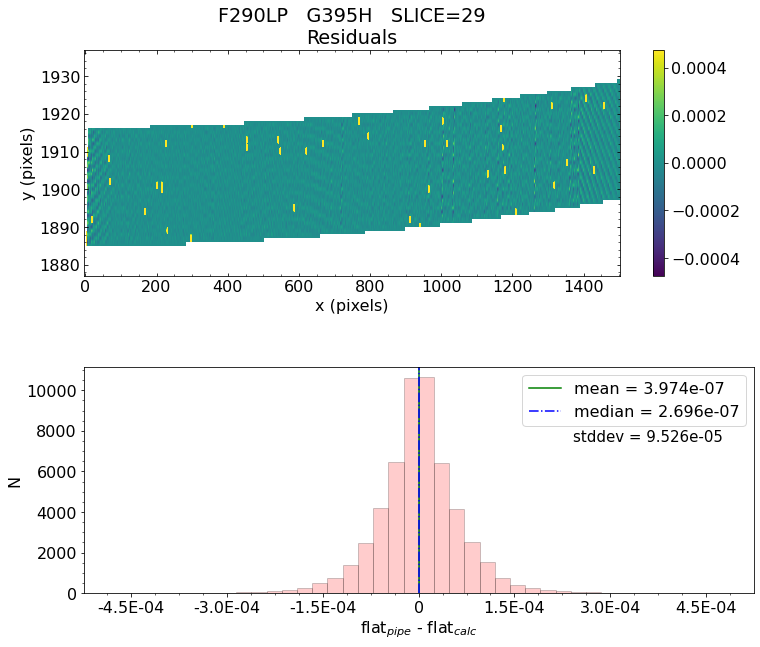

 *** Result of the test: PASSED


 *** Final result for flat_field test will be reported as PASSED *** 

('* Script flattest_ifu.py script took ', '58.10050334533056 minutes to finish.')


In [14]:
# Run the validation test
%matplotlib inline
result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.flattest_ifu.flattest(pipe_result,
                                                                                              dflat_path=dflat_path,
                                                                                              sflat_path=sflat_path, 
                                                                                              fflat_path=fflat_path,
                                                                                              writefile=writefile,
                                                                                              mk_all_slices_plt=False, 
                                                                                              show_figs=show_figs, 
                                                                                              save_figs=save_figs,
                                                                                              plot_name=None,
                                                                                              threshold_diff=threshold_diff,
                                                                                              debug=False)


In [15]:
# Quickly see if the test passed 
   
print("Did flat_field validation test for IFU passed? ", result_msg)


Did flat_field validation test for IFU passed?  All slices PASSED flat_field test.


<a id="results"></a>
## Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual slit (for FS data), slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.

<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Staff Scientist II - Systems Science Support, NIRSpec
<br>**Updated On:** 04/09/2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 